# [5] Assignment 9: Random Forests

<ol>
    <li><strong>Apply Random Forests & GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider two hyperparameters: n_estimators & max_depth)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 20 important features and represent them in a word cloud. Do this for BOW & TFIDF.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>(or)</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying RF

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from tqdm import tqdm
import os
con = sqlite3.connect(r"D:\AppliedAI\AAIC_Course_handouts\11_Amazon Fine Food Reviews\amazon-fine-food-reviews\database.sqlite")
data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""",con)

# Change Score with 1 n 2 as -ve and 4 n 5 as +ve

def chng_to_0_or_1 (Score):
    if Score ==4 or Score ==5:
        return 1
    elif Score ==1 or Score ==2:
        return 0
    else:# Thus in case by some mistake any data is their with rating 6 or 7 etc due to some error is removed
        pass
currentScore = data["Score"]
new_Score = currentScore.map(chng_to_0_or_1)
data["Score"] = new_Score
print ("Number of data points available")
print (data.shape)#Gives original number of data points available


#2 Data Cleaning a.) Getting rid of duplicates and b.) if helpnessdenominator < helpfulnessnumerator


data = data.drop_duplicates(subset = ["UserId","ProfileName","HelpfulnessNumerator","HelpfulnessDenominator","Score","Time","Summary","Text"], keep='first', inplace=False)
print ("Number of data points after removing duplicates")
print (data.shape)#Gives data points are deduplication

# Reference: Copied from above cell  final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
data=data[data.HelpfulnessNumerator<=data.HelpfulnessDenominator]
print ("Number of data points after removing where HelpfulnessNumerator is more than HelpfulnessDenominator ")
print (data.shape)

#3 Preprocessing begins

#Convert to lower case,convert shortcut words to proper words, remove Special Character

#i) Convert to lower case:
data["Text"] =  (data["Text"].str.lower())
data["Summary"] =  (data["Summary"].str.lower())

#ii) Convert Shortcuts words to proper words
#List of Words are:https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions
#Reference:https://stackoverflow.com/questions/39602824/pandas-replace-string-with-another-string
data['Text'] = data['Text'].replace({"ain't":"am not","amn't":"am not","aren't":"are not", \
"can't":"cannot","cause":"because","could've":"could have","couldn't":"could not","couldn't've":"could not have", \
"daren't":"dare not","daresn't":"dare not","dasn't":"dare not","didn't":"did not","doesn't":"does not", \
"don't":"do not","e'er":"ever","everyone's":"everyone is","finna":"fixing to","gimme":"give me", \
"gonna":"going to","gon't":"go not","gotta":"got to","hadn't":"had not","hasn't":"has not","haven't":"have not",\
"he'd":"he had","he'll":"he shall","he's":"he has","he've":"he have","how'd":"how did","how'll":"how will",\
"how're":"how are","how's":"how has","I'd":"I had","I'll":"I shall","I'm":"I am","I'm'a":"I am about to",\
"I'm'o":"I am going to","I've":"I have","isn't":"is not","it'd":"it would","it'll":"it shall","it's":"it has",\
"let's":"let us","mayn't":"may not","may've":"may have","mightn't":"might not","might've":"might have",\
"mustn't":"must not","mustn't've":"must not have","must've":"must have","needn't":"need not","ne'er":"never",\
"o'clock":"of the clock","o'er":"","ol'":"old","oughtn't":"ought not","shalln't":"shall not","shan't":"shall not",\
"she'd":"she had","she'll":"she shall","she's":"she is","should've":"should have","shouldn't":"should not",\
"shouldn't've":"should not have","somebody's":"somebody has","someone's":"someone has","something's":"something has",\
"that'll":"that will","that're":"that are","that's":"that is","that'd":"that would","there'd":"there had",\
"there'll":"there shall","there're":"there are","there's":"there is","these're":"hese are","they'd":"they had",\
"they'll":"they will","they're":"they are","they've":"they have","this's":"","those're":"those are","tis":"it is",\
"twas":"it was","wasn't":"was not","we'd":"we had","we'd've":"we would have","we'll":"we will","we're":"we are",\
"we've":"we have","weren't":"were not","what'd":"what did","what'll":"what will","what're":"what are","what's":"what is",\
"what've":"what have","when's":"when is","where'd":"where did","where're":"where are","where've":"where have",\
"which's":"which has","who'd":"who would","who'd've":"who would have","who'll":"who shall","who're":"who are",\
"who's":"who has","who've":"who have","why'd":"why did","why're":"why are","why's":"why has","won't":"will not",\
"would've":"would have","wouldn't":"would not","y'all":"you all","you'd":"you had","you'll":"you shall","you're":"you are",\
"you've":"you have"})
##############Lets do the same for summary Text##################################
data['Summary'] = data['Summary'].replace({"ain't":"am not","amn't":"am not","aren't":"are not", \
"can't":"cannot","cause":"because","could've":"could have","couldn't":"could not","couldn't've":"could not have", \
"daren't":"dare not","daresn't":"dare not","dasn't":"dare not","didn't":"did not","doesn't":"does not", \
"don't":"do not","e'er":"ever","everyone's":"everyone is","finna":"fixing to","gimme":"give me", \
"gonna":"going to","gon't":"go not","gotta":"got to","hadn't":"had not","hasn't":"has not","haven't":"have not",\
"he'd":"he had","he'll":"he shall","he's":"he has","he've":"he have","how'd":"how did","how'll":"how will",\
"how're":"how are","how's":"how has","I'd":"I had","I'll":"I shall","I'm":"I am","I'm'a":"I am about to",\
"I'm'o":"I am going to","I've":"I have","isn't":"is not","it'd":"it would","it'll":"it shall","it's":"it has",\
"let's":"let us","mayn't":"may not","may've":"may have","mightn't":"might not","might've":"might have",\
"mustn't":"must not","mustn't've":"must not have","must've":"must have","needn't":"need not","ne'er":"never",\
"o'clock":"of the clock","o'er":"","ol'":"old","oughtn't":"ought not","shalln't":"shall not","shan't":"shall not",\
"she'd":"she had","she'll":"she shall","she's":"she is","should've":"should have","shouldn't":"should not",\
"shouldn't've":"should not have","somebody's":"somebody has","someone's":"someone has","something's":"something has",\
"that'll":"that will","that're":"that are","that's":"that is","that'd":"that would","there'd":"there had",\
"there'll":"there shall","there're":"there are","there's":"there is","these're":"hese are","they'd":"they had",\
"they'll":"they will","they're":"they are","they've":"they have","this's":"","those're":"those are","tis":"it is",\
"twas":"it was","wasn't":"was not","we'd":"we had","we'd've":"we would have","we'll":"we will","we're":"we are",\
"we've":"we have","weren't":"were not","what'd":"what did","what'll":"what will","what're":"what are","what's":"what is",\
"what've":"what have","when's":"when is","where'd":"where did","where're":"where are","where've":"where have",\
"which's":"which has","who'd":"who would","who'd've":"who would have","who'll":"who shall","who're":"who are",\
"who's":"who has","who've":"who have","why'd":"why did","why're":"why are","why's":"why has","won't":"will not",\
"would've":"would have","wouldn't":"would not","y'all":"you all","you'd":"you had","you'll":"you shall","you're":"you are",\
"you've":"you have"})
########################################################################################
# iii) Remove Special Characters except alpahbets and numbers
#The reason i dont want to remove number people might write got five eggs as 5 eggs or vice versa and dont want to lose 
#that information which could be useful
#Ref:https://stackoverflow.com/questions/33257344/how-to-remove-special-characers-from-a-column-of-dataframe-using-module-re
data["Text"]=data["Text"].map(lambda x: re.sub(r'[^a-zA-Z_0-9 -]', '', x))
data["Summary_copy"]=data["Summary"].map(lambda x: re.sub(r'[^a-zA-Z_0-9 -]', '', x))

#The Summary are usually so small if we remove few stopwords the meaning itself would be complely lost or chamge
# So let us see what all stopwords we have
#Ref:::::::::https://stackoverflow.com/questions/5511708/adding-words-to-nltk-stoplist
#https://chrisalbon.com/machine_learning/preprocessing_text/remove_stop_words/

stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['would','could','br','<br>','<','>']
notstopwords = ['not','no','nor']
stopwords.extend(newStopWords)
stopwords = [word for word in stopwords if word not in notstopwords]

#  iv) For now let us just go with flow will use default stopwords as creating our own stop words is very time consuming
#Rather will use n-gram stratergy to get rid of problem of stopwords removal changing the meaning of sentences
#Ref:https://stackoverflow.com/questions/43184364/python-remove-stop-words-from-pandas-dataframe-give-wrong-output
data["New_Text"]= data['Text'].apply(lambda x: [item for item in str.split(x) if item not in stopwords])
data["Summary"]= data['Summary_copy'].apply(lambda x: [item for item in str.split(x) if item not in stopwords])

#Ref:https://stackoverflow.com/questions/37347725/converting-a-panda-df-list-into-a-string/37347837
#we are creating new column New_summary so in case in future we need summary it is intact
data["New_Text"]=data["New_Text"].apply(' '.join)
data["Summary"]=data["Summary"].apply(' '.join)

# v) Now lets do Stemming
#https://stackoverflow.com/questions/48617589/beginner-stemming-in-pandas-produces-letters-not-stems
english_stemmer=SnowballStemmer('english', ignore_stopwords=True)
data["New_Text"] = data["New_Text"].apply(english_stemmer.stem)
data["Summary"] = data["Summary"].apply(english_stemmer.stem)
data["New_Text"] = data["New_Text"].astype(str)
data["Summary"] = data["Summary"].astype(str)

#vi) stemming without removing stop words
english_stemmer=SnowballStemmer('english', ignore_stopwords=True)
#https://stackoverflow.com/questions/34724246/attributeerror-float-object-has-no-attribute-lower
data["Text_with_stop"]=data["Text"].astype(str)
data["Summary"]=data["Summary"].astype(str)
data["Text_with_stop"]=data["Text_with_stop"].str.lower().map(english_stemmer.stem)
data["Summary"]=data["Summary"].str.lower().map(english_stemmer.stem)
data["Text_with_stop"]=data["Text_with_stop"].apply(''.join)
data["Summary"]=data["Summary"].apply(''.join)
data["Text_with_stop"] = data["Text_with_stop"].astype(str)
data["Summary"] = data["Summary"].astype(str)
print(data["Score"].value_counts())
print ("Thus we see there are 85% and 15% positive and negative reviews,thus a unbalanced dataset.So to create a balanced \
dataset we first copy negative dataset 6 times than we sample with same number of times as positive")
# Let include another feature which is the length of the text 
data_neg = data[data["Score"] == 0]
data_pos = data[data["Score"] == 1]
data = pd.concat([data_pos,data_neg])
#https://stackoverflow.com/questions/46429033/how-do-i-count-the-total-number-of-words-in-a-pandas-dataframe-cell-and-add-thos
data["Text_length"]= (data["New_Text"].str.count(' ') + 1)
data["Summary_length"]= (data["Summary"].str.count(' ') + 1)
data["Time_formatted"]= pd.to_datetime(data["Time"])
data.sort_values(by=['Time_formatted'], inplace=True)


C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Number of data points available
(525814, 10)
Number of data points after removing duplicates
(366392, 10)
Number of data points after removing where HelpfulnessNumerator is more than HelpfulnessDenominator 
(366390, 10)
1    308679
0     57711
Name: Score, dtype: int64
Thus we see there are 85% and 15% positive and negative reviews,thus a unbalanced dataset.So to create a balanced dataset we first copy negative dataset 6 times than we sample with same number of times as positive


In [2]:
newdata = data.tail(40000)
newdata.sort_values(by=['Time_formatted'], inplace=True)

In [3]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split

Y_40k = newdata['Score'].values
X_no_stop_40k = newdata['New_Text'].values
X_summary_40k = newdata ['Summary'].values

X_no_stop_train_40k, X_no_stop_test_40k, y_train_40k, y_test_40k = train_test_split(X_no_stop_40k, Y_40k, test_size=0.33, shuffle=False)


### [5.1.1] Applying Random Forests on BOW,<font color='red'> SET 1</font>

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
import math

bow_vect = CountVectorizer(ngram_range = (1,2),min_df = 7,max_features=5000)
bow_X_train_no_stop_40k = bow_vect.fit_transform(X_no_stop_train_40k)
bow_X_test_no_stop_40k = bow_vect.transform(X_no_stop_test_40k)


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree, grid_search
from sklearn.grid_search import GridSearchCV

param_grid = {'max_depth':[10, 50, 100, 500, 1000],'n_estimators':5, 10, 50, 100, 200, 500, 1000]}
grid_RF_BOW = GridSearchCV(RandomForestClassifier(n_jobs=1,random_state=1,class_weight='balanced'),param_grid,scoring='roc_auc',cv=3, verbose=2)
grid_RF_BOW.fit(bow_X_train_no_stop_40k,y_train_40k)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] max_depth=10, n_estimators=5 ....................................
[CV] ........................... max_depth=10, n_estimators=5 -   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] max_depth=10, n_estimators=5 ....................................
[CV] ........................... max_depth=10, n_estimators=5 -   0.0s
[CV] max_depth=10, n_estimators=5 ....................................
[CV] ........................... max_depth=10, n_estimators=5 -   0.0s
[CV] max_depth=10, n_estimators=10 ...................................
[CV] .......................... max_depth=10, n_estimators=10 -   0.1s
[CV] max_depth=10, n_estimators=10 ...................................
[CV] .......................... max_depth=10, n_estimators=10 -   0.0s
[CV] max_depth=10, n_estimators=10 ...................................
[CV] .......................... max_depth=10, n_estimators=10 -   0.1s
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ......................... max_depth=10, n_estimators=100 -   1.0s
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ......................... max_depth=10, n_estimators=100 -   1.1s
[CV] m

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 56.8min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=1,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [10, 50, 100, 500, 1000], 'n_estimators': [5, 10, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=2)

In [10]:
grid_RF_BOW.best_params_

{'max_depth': 500, 'n_estimators': 1000}

In [11]:
besthyperpara_bow_RF = RandomForestClassifier(max_depth=500, n_estimators=1000,n_jobs=1,random_state=1,class_weight='balanced')
besthyperpara_bow_RF.fit(bow_X_train_no_stop_40k,y_train_40k)
pred_proba_train_bow_RF=(besthyperpara_bow_RF.predict_proba(bow_X_train_no_stop_40k)[:,1])
pred_proba_test_bow_RF=(besthyperpara_bow_RF.predict_proba(bow_X_test_no_stop_40k)[:,1])
roc_auc_test_bow_RF= (roc_auc_score(y_test_40k,pred_proba_test_bow_RF))
roc_auc_train_bow_RF  = (roc_auc_score(y_train_40k,pred_proba_train_bow_RF))


In [139]:
print (roc_auc_test_bow_RF)
print (roc_auc_train_bow_RF)

0.9378371780209235
0.9999999951919264


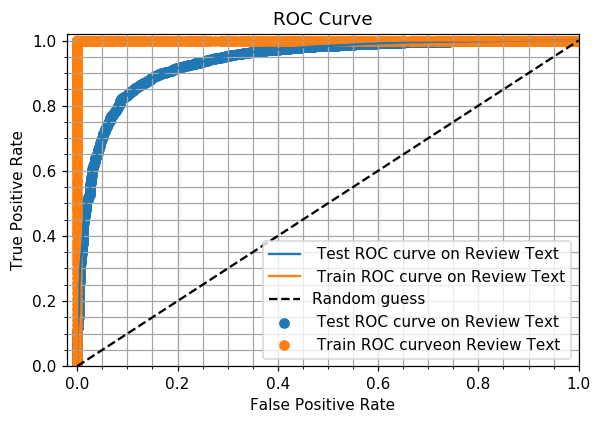

In [12]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr_test_bow_RF, tpr_test_bow_RF, thresholds = roc_curve(y_test_40k, pred_proba_test_bow_RF)
fpr_train_bow_RF, tpr_train_bow_RF, thresholds = roc_curve(y_train_40k, pred_proba_train_bow_RF)
# create plot
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.1
plt.plot(fpr_test_bow_RF, tpr_test_bow_RF, label=' Test ROC curve on Review Text')
plt.scatter(fpr_test_bow_RF, tpr_test_bow_RF, label=' Test ROC curve on Review Text')
plt.plot(fpr_train_bow_RF, tpr_train_bow_RF, label=' Train ROC curve on Review Text')
plt.scatter(fpr_train_bow_RF, tpr_train_bow_RF, label=' Train ROC curveon Review Text')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [22]:
Depth = [10, 50, 100, 500, 1000]
Estimators = [5, 10, 100, 500,1000]

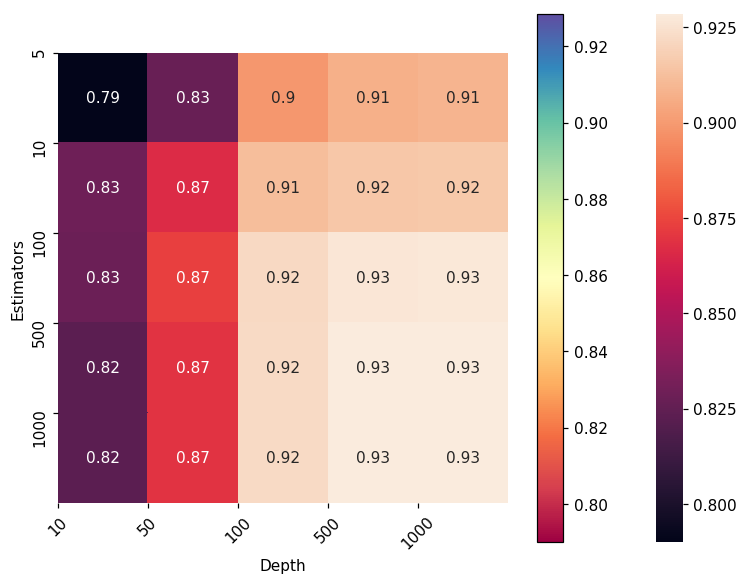

In [23]:
import numpy as np
import pylab as pl
import matplotlib.cm as cm
import seaborn as sns

# plot the scores of the grid
# grid_scores_ contains parameter settings and scores
score_dict = grid_RF_BOW.grid_scores_

# We extract just the scores
scores = [x[1] for x in score_dict]
scores = np.array(scores).reshape(len(Depth), len(Estimators))

# Make a nice figure
pl.figure(figsize=(8, 6))
pl.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
pl.imshow(scores, interpolation='nearest', cmap=cm.get_cmap("Spectral"))
ax = sns.heatmap(scores, annot=True)
pl.xlabel('Depth')
pl.ylabel('Estimators')
pl.colorbar()
pl.xticks(np.arange(len(Depth)), Depth, rotation=45)
pl.yticks(np.arange(len(Estimators)), Estimators)
pl.grid(False)
pl.show()


In [13]:
from sklearn.metrics import roc_auc_score
predict_RF_BOW_train = (grid_RF_BOW.predict(bow_X_train_no_stop_40k))
predict_RF_BOW_test = grid_RF_BOW.predict(bow_X_test_no_stop_40k)

roc_auc_RF_BOW_train = roc_auc_score(y_test_40k, predict_RF_BOW_test)
roc_auc_RF_BOW_test = roc_auc_score(y_train_40k, predict_RF_BOW_train)



In [140]:
print (roc_auc_RF_BOW_train)
print (roc_auc_RF_BOW_test)

0.7186606080316951
0.99997736839723


In [14]:
from sklearn.metrics import classification_report

print ("#######################################################")
print ("The classification report on Test dataset on Review Text")
print ("#######################################################")

print(classification_report(y_test_40k, predict_RF_BOW_test))


print ("#######################################################")
print ("The classification report on Training dataset Review Text")
print ("#######################################################")
print(classification_report(y_train_40k, predict_RF_BOW_train))



#######################################################
The classification report on Test dataset on Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.87      0.45      0.59      2156
          1       0.90      0.99      0.94     11044

avg / total       0.90      0.90      0.89     13200

#######################################################
The classification report on Training dataset Review Text
#######################################################
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      4707
          1       1.00      1.00      1.00     22093

avg / total       1.00      1.00      1.00     26800



The first matrix is that of Test in normalized format
The second matrix is that of Train in normalized format
The third matrix is that of Test in non normalized format
The fourth matrix is that of Train in non normalized format


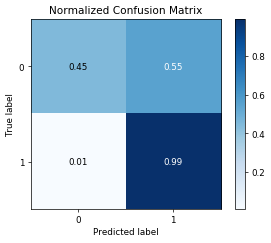

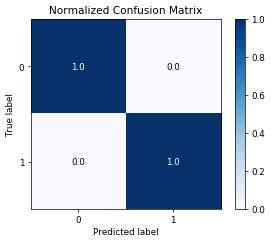

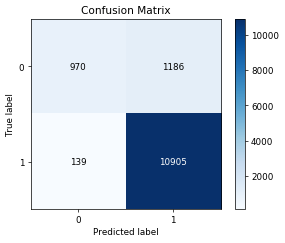

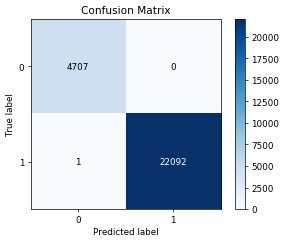

In [15]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_test_40k, predict_RF_BOW_test,normalize=True)
print ("The first matrix is that of Test in normalized format")
print ("The second matrix is that of Train in normalized format")
print ("The third matrix is that of Test in non normalized format")
print ("The fourth matrix is that of Train in non normalized format")
skplt.plot_confusion_matrix(y_train_40k, predict_RF_BOW_train,normalize=True)
skplt.plot_confusion_matrix(y_test_40k, predict_RF_BOW_test)
skplt.plot_confusion_matrix(y_train_40k, predict_RF_BOW_train)


### [5.1.2] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

In [89]:
# https://github.com/Manish-12/Decision-Tree-on-Amazon-fine-food-reviews/blob/master/Decision_tree.ipynb

top_20_feature_bow = besthyperpara_bow_RF.feature_importances_.argsort()[::-1][:20]
top_20_feature_bow_word = (np.take(bow_vect.get_feature_names(),top_20_feature_tfidf))

print ("The Top 20 features are")
top_20_feature_bow_word_list = ((top_20_feature_bow_word).tolist())
print (top_20_feature_bow_word_list)



The Top 20 features are
['not', 'great', 'love', 'best', 'disappointed', 'good', 'perfect', 'delicious', 'bad', 'money', 'loves', 'nice', 'product', 'return', 'easy', 'favorite', 'excellent', 'horrible', 'waste', 'not buy']


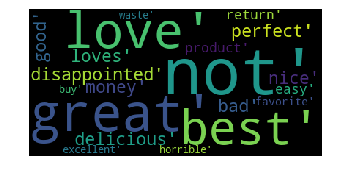

In [90]:
wordcloud = WordCloud(relative_scaling = 1.0).generate(str(top_20_feature_bow_word_list))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### [5.1.3] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df = 7,max_features=5000)
tfidf_X_train = tf_idf_vect.fit_transform(X_no_stop_train_40k)
tfidf_X_test = tf_idf_vect.transform(X_no_stop_test_40k)

In [17]:
from sklearn import tree, grid_search
from sklearn.grid_search import GridSearchCV

param_grid = {'max_depth':[10, 50, 100, 500, 1000],'n_estimators':[5, 10, 100, 500,1000]}
grid_RF_tfidf = GridSearchCV(RandomForestClassifier(n_jobs=1,random_state=1,class_weight='balanced'),param_grid,scoring='roc_auc',cv=3, verbose=2)
grid_RF_tfidf.fit(tfidf_X_train,y_train_40k)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] max_depth=10, n_estimators=5 ....................................
[CV] ........................... max_depth=10, n_estimators=5 -   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] max_depth=10, n_estimators=5 ....................................
[CV] ........................... max_depth=10, n_estimators=5 -   0.0s
[CV] max_depth=10, n_estimators=5 ....................................
[CV] ........................... max_depth=10, n_estimators=5 -   0.0s
[CV] max_depth=10, n_estimators=10 ...................................
[CV] .......................... max_depth=10, n_estimators=10 -   0.1s
[CV] max_depth=10, n_estimators=10 ...................................
[CV] .......................... max_depth=10, n_estimators=10 -   0.1s
[CV] max_depth=10, n_estimators=10 ...................................
[CV] .......................... max_depth=10, n_estimators=10 -   0.1s
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ......................... max_depth=10, n_estimators=100 -   1.4s
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ......................... max_depth=10, n_estimators=100 -   1.3s
[CV] m

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 54.5min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=1,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [10, 50, 100, 500, 1000], 'n_estimators': [5, 10, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=2)

In [18]:
grid_RF_tfidf.best_params_

{'max_depth': 500, 'n_estimators': 1000}

In [19]:
besthyperpara_tfidf_RF = RandomForestClassifier(max_depth=500,n_estimators=1000,n_jobs=1,random_state=1,class_weight='balanced')
besthyperpara_tfidf_RF.fit(tfidf_X_train,y_train_40k)
pred_proba_train_tfidf_RF=(besthyperpara_tfidf_RF.predict_proba(tfidf_X_train)[:,1])
pred_proba_test_tfidf_RF=(besthyperpara_tfidf_RF.predict_proba(tfidf_X_test)[:,1])
roc_auc_test_tfidf_RF= (roc_auc_score(y_test_40k,pred_proba_test_tfidf_RF))
roc_auc_train_tfidf_RF  = (roc_auc_score(y_train_40k,pred_proba_train_tfidf_RF))

In [141]:
print (roc_auc_test_tfidf_RF)
print (roc_auc_train_tfidf_RF)

0.9395840276942493
0.9999999951919263


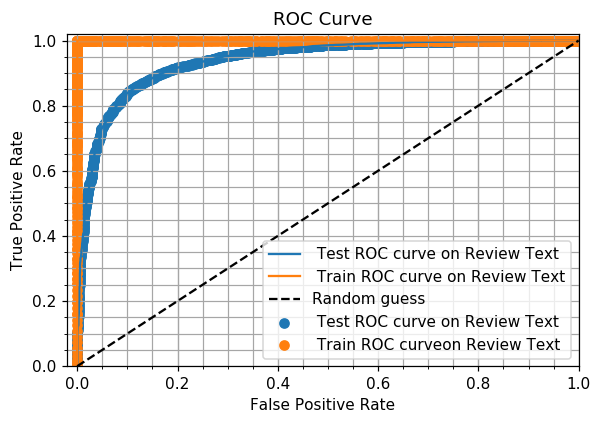

In [20]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr_test_tfidf_RF, tpr_test_tfidf_RF, thresholds = roc_curve(y_test_40k,pred_proba_test_tfidf_RF)
fpr_train_tfidf_RF, tpr_train_tfidf_RF, thresholds = roc_curve(y_train_40k,pred_proba_train_tfidf_RF)
# create plot
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.1
plt.plot(fpr_test_tfidf_RF, tpr_test_tfidf_RF, label=' Test ROC curve on Review Text')
plt.scatter(fpr_test_tfidf_RF, tpr_test_tfidf_RF, label=' Test ROC curve on Review Text')
plt.plot(fpr_train_tfidf_RF, tpr_train_tfidf_RF, label=' Train ROC curve on Review Text')
plt.scatter(fpr_train_tfidf_RF, tpr_train_tfidf_RF, label=' Train ROC curveon Review Text')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [21]:
from sklearn.metrics import roc_auc_score
predict_RF_tfidf_train = grid_RF_tfidf.predict(tfidf_X_train)
predict_RF_tfidf_test = grid_RF_tfidf.predict(tfidf_X_test)

roc_auc_RF_tfidf_train = roc_auc_score(y_test_40k, predict_RF_tfidf_test)
roc_auc_RF_tfidf_test = roc_auc_score(y_train_40k, predict_RF_tfidf_train)

In [24]:
Depth = [10, 50, 100, 500, 1000]
Estimators = [5, 10, 100, 500,1000]

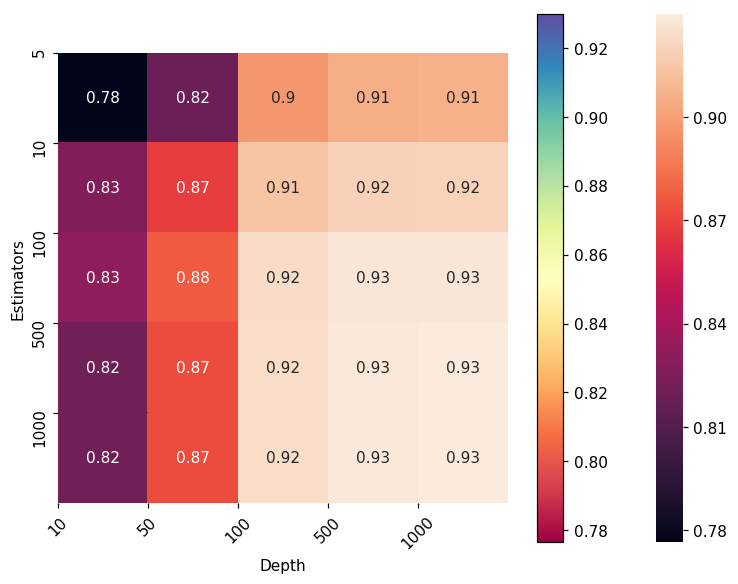

In [26]:
import numpy as np
import pylab as pl
import matplotlib.cm as cm
import seaborn as sns

# plot the scores of the grid
# grid_scores_ contains parameter settings and scores
score_dict_tfidf = grid_RF_tfidf.grid_scores_

# We extract just the scores
scores = [x[1] for x in score_dict_tfidf]
scores = np.array(scores).reshape(len(Depth), len(Estimators))

# Make a nice figure
pl.figure(figsize=(8, 6))
pl.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
pl.imshow(scores, interpolation='nearest', cmap=cm.get_cmap("Spectral"))
ax = sns.heatmap(scores, annot=True)
pl.xlabel('Depth')
pl.ylabel('Estimators')
pl.colorbar()
pl.xticks(np.arange(len(Depth)), Depth, rotation=45)
pl.yticks(np.arange(len(Estimators)), Estimators)
pl.grid(False)
pl.show()


In [27]:
from sklearn.metrics import classification_report

print ("#######################################################")
print ("The classification report on Test dataset on Review Text")
print ("#######################################################")

print(classification_report(y_test_40k, predict_RF_tfidf_test))


print ("#######################################################")
print ("The classification report on Training dataset Review Text")
print ("#######################################################")
print(classification_report(y_train_40k, predict_RF_tfidf_train))

#######################################################
The classification report on Test dataset on Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.89      0.43      0.58      2156
          1       0.90      0.99      0.94     11044

avg / total       0.90      0.90      0.88     13200

#######################################################
The classification report on Training dataset Review Text
#######################################################
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      4707
          1       1.00      1.00      1.00     22093

avg / total       1.00      1.00      1.00     26800



The first matrix is that of Test in normalized format
The second matrix is that of Train in normalized format
The third matrix is that of Test in non normalized format
The fourth matrix is that of Train in non normalized format


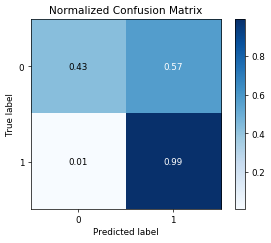

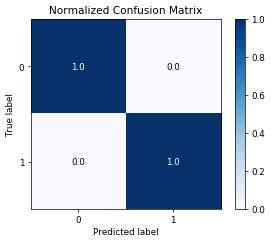

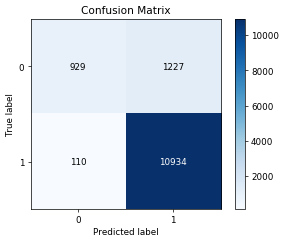

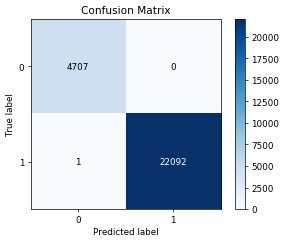

In [28]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_test_40k, predict_RF_tfidf_test,normalize=True)
print ("The first matrix is that of Test in normalized format")
print ("The second matrix is that of Train in normalized format")
print ("The third matrix is that of Test in non normalized format")
print ("The fourth matrix is that of Train in non normalized format")
skplt.plot_confusion_matrix(y_train_40k, predict_RF_tfidf_train,normalize=True)
skplt.plot_confusion_matrix(y_test_40k, predict_RF_tfidf_test)
skplt.plot_confusion_matrix(y_train_40k, predict_RF_tfidf_train)

### [5.1.4] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

In [86]:
# https://github.com/Manish-12/Decision-Tree-on-Amazon-fine-food-reviews/blob/master/Decision_tree.ipynb
top_20_feature_tfidf = besthyperpara_tfidf_RF.feature_importances_.argsort()[::-1][:20]

top_20_feature_tfidf_word = (np.take(tf_idf_vect.get_feature_names(),top_20_feature_tfidf))

In [87]:
print ("The Top 20 features are")
top_20_feature_tfidf_word_list = ((top_20_feature_tfidf_word).tolist())
print (top_20_feature_tfidf_word_list)

The Top 20 features are
['not', 'great', 'love', 'best', 'disappointed', 'good', 'perfect', 'delicious', 'bad', 'money', 'loves', 'nice', 'product', 'return', 'easy', 'favorite', 'excellent', 'horrible', 'waste', 'not buy']


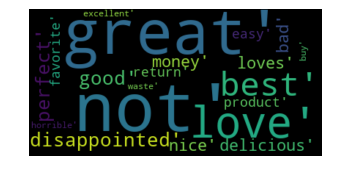

In [88]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
 
#wordcloud = WordCloud().generate(top_20_feature_tfidf_word_list)
wordcloud = WordCloud().generate(str(top_20_feature_tfidf_word_list))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()


### [5.1.5] Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

In [25]:
lst_train=[]
lst_test=[]
lst_of_lst_train = []
lst_of_lst_test = []

for sentance in tqdm(X_no_stop_train_40k):
    lst_train.append(sentance.strip())
for sentance in tqdm(lst_train):
    lst_of_lst_train.append(sentance.split())

for sent in tqdm(X_no_stop_test_40k):
    lst_test.append(sent.strip())
for sent in tqdm(lst_test):
    lst_of_lst_test.append(sent.split())
    
    
w2v_model_self_taught_train=Word2Vec(lst_of_lst_train,min_count=1,size=50, workers=4)
w2v_words_train = list(w2v_model_self_taught_train.wv.vocab)


100%|████████████████████████████████████████████████████████████████████████| 13200/13200 [00:00<00:00, 240648.57it/s]


In [26]:
sent_vectors_train = []
for sent1 in tqdm(lst_of_lst_train): # for each review/sentence
    sent_vec1 = np.zeros(50)
    cnt_words1 = 0
    for word1 in sent1:
        if word1 in w2v_words_train:
            vec1 = w2v_model_self_taught_train.wv[word1]
            sent_vec1 += vec1
            cnt_words1 += 1
    if cnt_words1 != 0:
        sent_vec1 /= cnt_words1
    sent_vectors_train.append(sent_vec1) 

100%|███████████████████████████████████████████████████████████████████████████| 26800/26800 [01:24<00:00, 316.23it/s]


In [27]:
sent_vectors_test = []
for sent2 in tqdm(lst_of_lst_test): # for each review/sentence
    sent_vec2 = np.zeros(50)
    cnt_words2 = 0
    for word2 in sent2:
        if word2 in w2v_words_train:
            vec2 = w2v_model_self_taught_train.wv[word2]
            sent_vec2 += vec2
            cnt_words2 += 1
    if cnt_words2 != 0:
        sent_vec2 /= cnt_words2
    sent_vectors_test.append(sent_vec2)

100%|███████████████████████████████████████████████████████████████████████████| 13200/13200 [00:51<00:00, 256.80it/s]


In [32]:
from sklearn import tree, grid_search
from sklearn.grid_search import GridSearchCV

param_grid = {'max_depth':[10, 50, 100, 500, 1000],'n_estimators':[5, 10, 100, 500,1000]}
grid_RF_avgw2v = GridSearchCV(RandomForestClassifier(n_jobs=1,random_state=1,class_weight='balanced'),param_grid,scoring='roc_auc',cv=3, verbose=2)
grid_RF_avgw2v.fit(sent_vectors_train,y_train_40k)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] max_depth=10, n_estimators=5 ....................................
[CV] ........................... max_depth=10, n_estimators=5 -   0.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] max_depth=10, n_estimators=5 ....................................
[CV] ........................... max_depth=10, n_estimators=5 -   0.4s
[CV] max_depth=10, n_estimators=5 ....................................
[CV] ........................... max_depth=10, n_estimators=5 -   0.4s
[CV] max_depth=10, n_estimators=10 ...................................
[CV] .......................... max_depth=10, n_estimators=10 -   0.8s
[CV] max_depth=10, n_estimators=10 ...................................
[CV] .......................... max_depth=10, n_estimators=10 -   0.8s
[CV] max_depth=10, n_estimators=10 ...................................
[CV] .......................... max_depth=10, n_estimators=10 -   0.8s
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ......................... max_depth=10, n_estimators=100 -   8.9s
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ......................... max_depth=10, n_estimators=100 -   9.1s
[CV] m

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 45.2min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=1,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [10, 50, 100, 500, 1000], 'n_estimators': [5, 10, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=2)

In [33]:
grid_RF_avgw2v.best_params_

{'max_depth': 50, 'n_estimators': 1000}

In [35]:
besthyperpara_avgw2v_RF = RandomForestClassifier(max_depth=50,n_estimators=1000,n_jobs=1,random_state=1,class_weight='balanced')
besthyperpara_avgw2v_RF.fit(sent_vectors_train,y_train_40k)
pred_proba_train_avgw2v_RF=(besthyperpara_avgw2v_RF.predict_proba(sent_vectors_train)[:,1])
pred_proba_test_avgw2v_RF=(besthyperpara_avgw2v_RF.predict_proba(sent_vectors_test)[:,1])
roc_auc_test_avgw2v_RF= (roc_auc_score(y_test_40k,pred_proba_test_avgw2v_RF))
roc_auc_train_avgw2v_RF  = (roc_auc_score(y_train_40k,pred_proba_train_avgw2v_RF))


In [142]:
print (roc_auc_test_avgw2v_RF)
print (roc_auc_train_avgw2v_RF)

0.885367095456931
0.9999999951919263


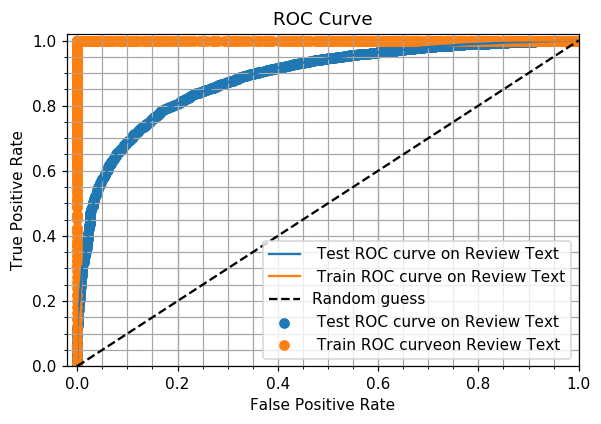

In [36]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr_test_avgw2v_RF, tpr_test_avgw2v_RF, thresholds = roc_curve(y_test_40k,pred_proba_test_avgw2v_RF)
fpr_train_avgw2v_RF, tpr_train_avgw2v_RF, thresholds = roc_curve(y_train_40k,pred_proba_train_avgw2v_RF)
# create plot
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.1
plt.plot(fpr_test_avgw2v_RF, tpr_test_avgw2v_RF, label=' Test ROC curve on Review Text')
plt.scatter(fpr_test_avgw2v_RF, tpr_test_avgw2v_RF, label=' Test ROC curve on Review Text')
plt.plot(fpr_train_avgw2v_RF, tpr_train_avgw2v_RF, label=' Train ROC curve on Review Text')
plt.scatter(fpr_train_avgw2v_RF, tpr_train_avgw2v_RF, label=' Train ROC curveon Review Text')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

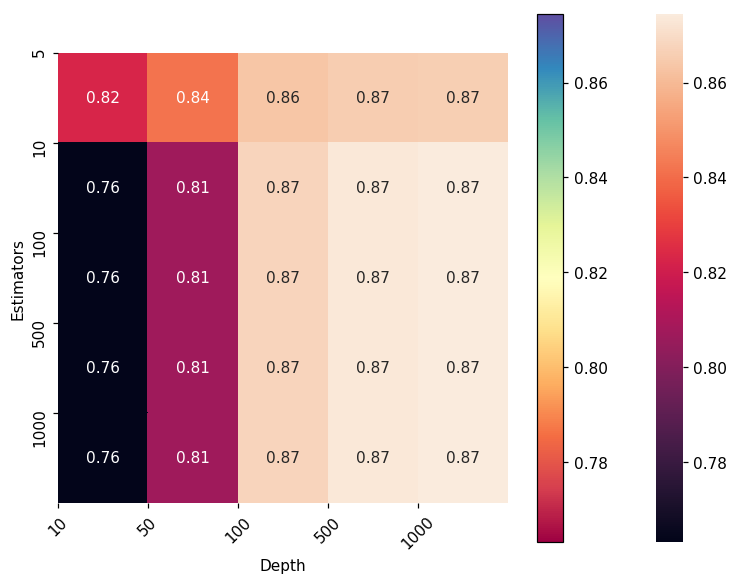

In [37]:
Depth = [10, 50, 100, 500, 1000]
Estimators = [5, 10, 100, 500,1000]

import numpy as np
import pylab as pl
import matplotlib.cm as cm
import seaborn as sns

# plot the scores of the grid
# grid_scores_ contains parameter settings and scores
score_dict_avgw2v = grid_RF_avgw2v.grid_scores_

# We extract just the scores
scores = [x[1] for x in score_dict_avgw2v]
scores = np.array(scores).reshape(len(Depth), len(Estimators))

# Make a nice figure
pl.figure(figsize=(8, 6))
pl.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
pl.imshow(scores, interpolation='nearest', cmap=cm.get_cmap("Spectral"))
ax = sns.heatmap(scores, annot=True)
pl.xlabel('Depth')
pl.ylabel('Estimators')
pl.colorbar()
pl.xticks(np.arange(len(Depth)), Depth, rotation=45)
pl.yticks(np.arange(len(Estimators)), Estimators)
pl.grid(False)
pl.show()


In [38]:
from sklearn.metrics import roc_auc_score
predict_RF_avgw2v_train = grid_RF_avgw2v.predict(sent_vectors_train)
predict_RF_avgw2v_test = grid_RF_avgw2v.predict(sent_vectors_test)


from sklearn.metrics import classification_report

print ("#######################################################")
print ("The classification report on Test dataset on Review Text")
print ("#######################################################")

print(classification_report(y_test_40k, predict_RF_avgw2v_test))


print ("#######################################################")
print ("The classification report on Training dataset Review Text")
print ("#######################################################")
print(classification_report(y_train_40k, predict_RF_avgw2v_train))



#######################################################
The classification report on Test dataset on Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.77      0.25      0.38      2156
          1       0.87      0.98      0.92     11044

avg / total       0.85      0.87      0.84     13200

#######################################################
The classification report on Training dataset Review Text
#######################################################
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      4707
          1       1.00      1.00      1.00     22093

avg / total       1.00      1.00      1.00     26800



In [39]:
roc_auc_RF_avgw2v_train = roc_auc_score(y_test_40k, predict_RF_avgw2v_test)
roc_auc_RF_avgw2v_test = roc_auc_score(y_train_40k, predict_RF_avgw2v_train)

The first matrix is that of Test in normalized format
The second matrix is that of Train in normalized format
The third matrix is that of Test in non normalized format
The fourth matrix is that of Train in non normalized format


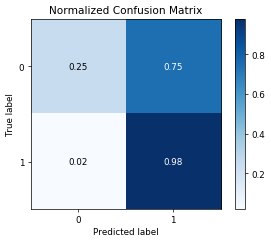

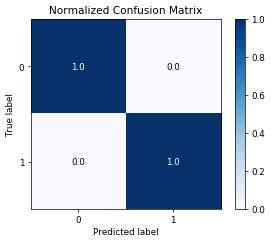

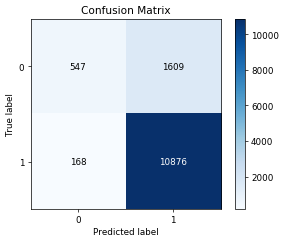

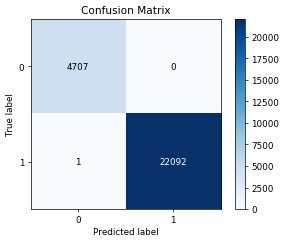

In [40]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_test_40k, predict_RF_avgw2v_test,normalize=True)
print ("The first matrix is that of Test in normalized format")
print ("The second matrix is that of Train in normalized format")
print ("The third matrix is that of Test in non normalized format")
print ("The fourth matrix is that of Train in non normalized format")
skplt.plot_confusion_matrix(y_train_40k, predict_RF_avgw2v_train,normalize=True)
skplt.plot_confusion_matrix(y_test_40k, predict_RF_avgw2v_test)
skplt.plot_confusion_matrix(y_train_40k, predict_RF_avgw2v_train)


### [5.1.6] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

In [40]:
model_tfidfw2v = TfidfVectorizer()
model_tfidfw2v.fit(X_no_stop_train_40k)
dictionary = dict(zip(model_tfidfw2v.get_feature_names(), list(model_tfidfw2v.idf_)))
tfidf_feat_tfidfw2v = model_tfidfw2v.get_feature_names() 

In [41]:
tfidf_w2v_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent4 in tqdm(lst_of_lst_train): # for each review/sentence 
    sent_vec4 = np.zeros(50) # as word vectors are of zero length
    weight_sum4 =0; # num of words with a valid vector in the sentence/review
    for word4 in sent4: # for each word in a review/sentence
        if word4 in w2v_words_train and word4 in tfidf_feat_tfidfw2v:
            vec4 = w2v_model_self_taught_train.wv[word4]
            tf_idf_train = dictionary[word4]*(sent4.count(word4)/len(sent4))
            sent_vec4 += (vec4 * tf_idf_train)
            weight_sum4 += tf_idf_train
    if weight_sum4 != 0:
        sent_vec4 /= weight_sum4
    tfidf_w2v_sent_vectors_train.append(sent_vec4)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 26800/26800 [08:54<00:00, 50.14it/s]


In [42]:
tfidf_w2v_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent5 in tqdm(lst_of_lst_test): # for each review/sentence 
    sent_vec5 = np.zeros(50) # as word vectors are of zero length
    weight_sum5 =0; # num of words with a valid vector in the sentence/review
    for word5 in sent5: # for each word in a review/sentence
        if word5 in w2v_words_train and word5 in tfidf_feat_tfidfw2v:
            vec5 = w2v_model_self_taught_train.wv[word5]
            tf_idf_test = dictionary[word5]*(sent5.count(word5)/len(sent5))
            sent_vec5 += (vec5 * tf_idf_test)
            weight_sum5 += tf_idf_test
    if weight_sum5 != 0:
        sent_vec5 /= weight_sum5
    tfidf_w2v_sent_vectors_test.append(sent_vec5)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 13200/13200 [04:16<00:00, 51.49it/s]


In [73]:
from sklearn import tree, grid_search
from sklearn.grid_search import GridSearchCV

param_grid = {'max_depth':[10, 50, 100, 500, 1000],'n_estimators':[5, 10, 100, 500,1000]}
grid_RF_tfidfw2v = GridSearchCV(RandomForestClassifier(n_jobs=1,random_state=1,class_weight='balanced'),param_grid,scoring='roc_auc',cv=3, verbose=2)
grid_RF_tfidfw2v.fit(tfidf_w2v_sent_vectors_train,y_train_40k)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] max_depth=10, n_estimators=5 ....................................
[CV] ........................... max_depth=10, n_estimators=5 -   0.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] max_depth=10, n_estimators=5 ....................................
[CV] ........................... max_depth=10, n_estimators=5 -   0.4s
[CV] max_depth=10, n_estimators=5 ....................................
[CV] ........................... max_depth=10, n_estimators=5 -   0.4s
[CV] max_depth=10, n_estimators=10 ...................................
[CV] .......................... max_depth=10, n_estimators=10 -   0.9s
[CV] max_depth=10, n_estimators=10 ...................................
[CV] .......................... max_depth=10, n_estimators=10 -   0.9s
[CV] max_depth=10, n_estimators=10 ...................................
[CV] .......................... max_depth=10, n_estimators=10 -   0.9s
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ......................... max_depth=10, n_estimators=100 -   9.1s
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ......................... max_depth=10, n_estimators=100 -   9.1s
[CV] m

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 45.0min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=1,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [10, 50, 100, 500, 1000], 'n_estimators': [5, 10, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=2)

In [74]:
grid_RF_tfidfw2v.best_params_

{'max_depth': 50, 'n_estimators': 1000}

In [75]:
besthyperpara_tfidfw2v_RF = RandomForestClassifier(max_depth=50,n_estimators=1000,n_jobs=1,random_state=1,class_weight='balanced')
besthyperpara_tfidfw2v_RF.fit(tfidf_w2v_sent_vectors_train,y_train_40k)
pred_proba_train_tfidfw2v_RF=(besthyperpara_tfidfw2v_RF.predict_proba(tfidf_w2v_sent_vectors_train)[:,1])
pred_proba_test_tfidfw2v_RF=(besthyperpara_tfidfw2v_RF.predict_proba(tfidf_w2v_sent_vectors_test)[:,1])
roc_auc_test_tfidfw2v_RF_= (roc_auc_score(y_test_40k,pred_proba_test_tfidfw2v_RF))
roc_auc_train_tfidfw2v_RF  = (roc_auc_score(y_train_40k,pred_proba_train_tfidfw2v_RF))


In [143]:
print (roc_auc_test_tfidfw2v_RF_)
print (roc_auc_train_tfidfw2v_RF)

0.8640147203394215
0.9999999951919263


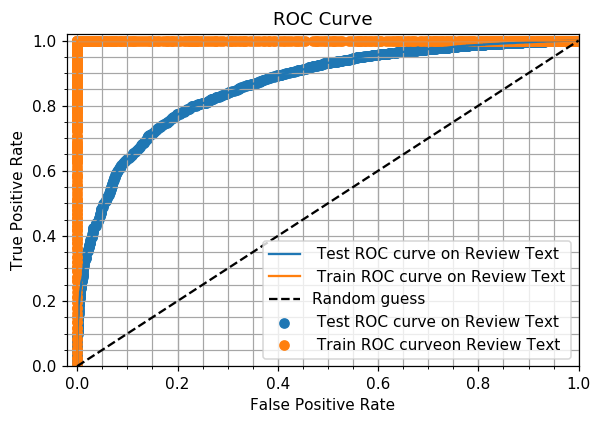

In [76]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr_test_tfidfw2v_RF, tpr_test_tfidfw2v_RF, thresholds = roc_curve(y_test_40k,pred_proba_test_tfidfw2v_RF)
fpr_train_tfidfw2v_RF, tpr_train_tfidfw2v_RF, thresholds = roc_curve(y_train_40k,pred_proba_train_tfidfw2v_RF)
# create plot
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.1
plt.plot(fpr_test_tfidfw2v_RF, tpr_test_tfidfw2v_RF, label=' Test ROC curve on Review Text')
plt.scatter(fpr_test_tfidfw2v_RF, tpr_test_tfidfw2v_RF, label=' Test ROC curve on Review Text')
plt.plot(fpr_train_tfidfw2v_RF, tpr_train_tfidfw2v_RF, label=' Train ROC curve on Review Text')
plt.scatter(fpr_train_tfidfw2v_RF, tpr_train_tfidfw2v_RF, label=' Train ROC curveon Review Text')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

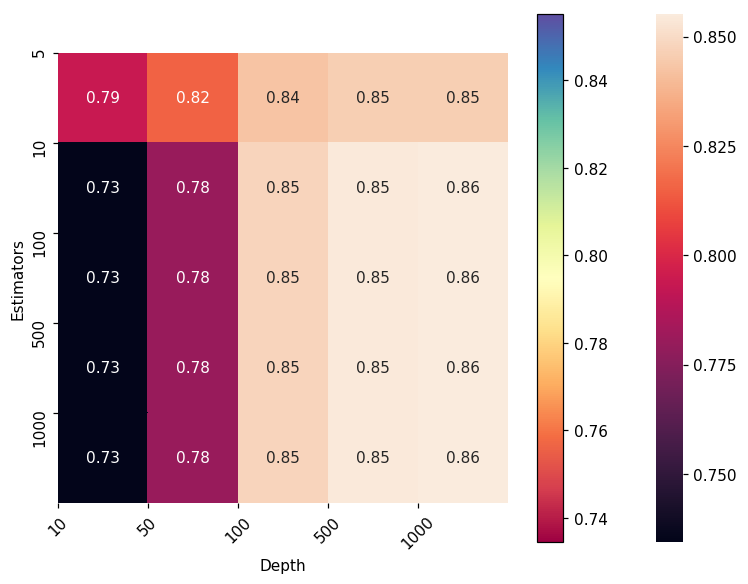

In [77]:
Depth = [10, 50, 100, 500, 1000]
Estimators = [5, 10, 100, 500,1000]

import numpy as np
import pylab as pl
import matplotlib.cm as cm
import seaborn as sns

# plot the scores of the grid
# grid_scores_ contains parameter settings and scores
score_dict_tfidfw2v = grid_RF_tfidfw2v.grid_scores_

# We extract just the scores
scores = [x[1] for x in score_dict_tfidfw2v]
scores = np.array(scores).reshape(len(Depth), len(Estimators))

# Make a nice figure
pl.figure(figsize=(8, 6))
pl.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
pl.imshow(scores, interpolation='nearest', cmap=cm.get_cmap("Spectral"))
ax = sns.heatmap(scores, annot=True)
pl.xlabel('Depth')
pl.ylabel('Estimators')
pl.colorbar()
pl.xticks(np.arange(len(Depth)), Depth, rotation=45)
pl.yticks(np.arange(len(Estimators)), Estimators)
pl.grid(False)
pl.show()


In [78]:
from sklearn.metrics import roc_auc_score
predict_RF_tfidfw2v_train = grid_RF_tfidfw2v.predict(tfidf_w2v_sent_vectors_train)
predict_RF_tfidfw2v_test = grid_RF_tfidfw2v.predict(tfidf_w2v_sent_vectors_test)


from sklearn.metrics import classification_report

print ("#######################################################")
print ("The classification report on Test dataset on Review Text")
print ("#######################################################")

print(classification_report(y_test_40k, predict_RF_tfidfw2v_test))


print ("#######################################################")
print ("The classification report on Training dataset Review Text")
print ("#######################################################")
print(classification_report(y_train_40k, predict_RF_tfidfw2v_train))



#######################################################
The classification report on Test dataset on Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.74      0.21      0.33      2156
          1       0.86      0.99      0.92     11044

avg / total       0.84      0.86      0.82     13200

#######################################################
The classification report on Training dataset Review Text
#######################################################
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      4707
          1       1.00      1.00      1.00     22093

avg / total       1.00      1.00      1.00     26800



In [79]:
roc_auc_DT_tfidfw2v_train = roc_auc_score(y_test_40k, predict_RF_tfidfw2v_test)
roc_auc_DT_tfidfw2v_test = roc_auc_score(y_train_40k, predict_RF_tfidfw2v_train)

The first matrix is that of Test in normalized format
The second matrix is that of Train in normalized format
The third matrix is that of Test in non normalized format
The fourth matrix is that of Train in non normalized format


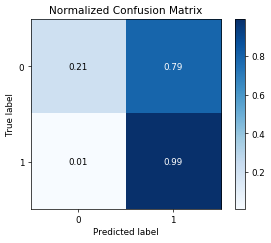

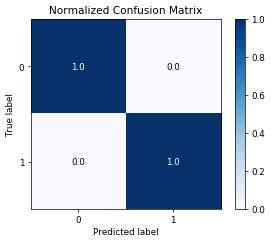

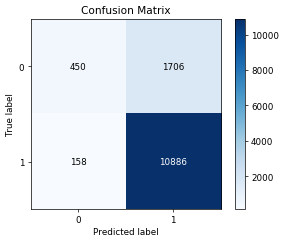

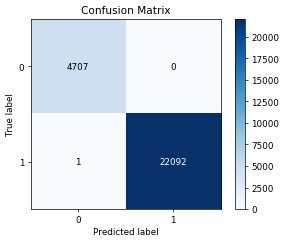

In [81]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_test_40k, predict_RF_tfidfw2v_test,normalize=True)
print ("The first matrix is that of Test in normalized format")
print ("The second matrix is that of Train in normalized format")
print ("The third matrix is that of Test in non normalized format")
print ("The fourth matrix is that of Train in non normalized format")
skplt.plot_confusion_matrix(y_train_40k, predict_RF_tfidfw2v_train,normalize=True)
skplt.plot_confusion_matrix(y_test_40k, predict_RF_tfidfw2v_test)
skplt.plot_confusion_matrix(y_train_40k, predict_RF_tfidfw2v_train)

## [5.2] Applying GBDT using XGBOOST

### [5.2.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

In [6]:
from lightgbm import LGBMClassifier

from scipy.stats import uniform, randint
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
import warnings
warnings.filterwarnings("ignore")


lgbm = LGBMClassifier(random_state=5,class_weight='balanced')

param_grid = {'max_depth':[2, 3, 4, 5, 6, 7, 8, 9, 10],'n_estimators':[5, 10, 50, 100, 200, 500, 1000]}
gbdt_lgbm_BOW = GridSearchCV(lgbm,param_grid,scoring='roc_auc',cv=3, verbose=2)
gbdt_lgbm_BOW.fit(bow_X_train_no_stop_40k.astype(np.float32),y_train_40k.astype(np.float32))
gbdt_lgbm_BOW.best_params_

Fitting 3 folds for each of 63 candidates, totalling 189 fits
[CV] max_depth=2, n_estimators=5 .....................................
[CV] ...................... max_depth=2, n_estimators=5, total=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] max_depth=2, n_estimators=5 .....................................
[CV] ...................... max_depth=2, n_estimators=5, total=   0.2s
[CV] max_depth=2, n_estimators=5 .....................................
[CV] ...................... max_depth=2, n_estimators=5, total=   0.2s
[CV] max_depth=2, n_estimators=10 ....................................
[CV] ..................... max_depth=2, n_estimators=10, total=   0.3s
[CV] max_depth=2, n_estimators=10 ....................................
[CV] ..................... max_depth=2, n_estimators=10, total=   0.2s
[CV] max_depth=2, n_estimators=10 ....................................
[CV] ..................... max_depth=2, n_estimators=10, total=   0.2s
[CV] max_depth=2, n_estimators=50 ....................................
[CV] ..................... max_depth=2, n_estimators=50, total=   0.4s
[CV] max_depth=2, n_estimators=50 ....................................
[CV] ..................... max_depth=2, n_estimators=50, total=   0.4s
[CV] m

[CV] .................... max_depth=4, n_estimators=500, total=   3.6s
[CV] max_depth=4, n_estimators=500 ...................................
[CV] .................... max_depth=4, n_estimators=500, total=   3.7s
[CV] max_depth=4, n_estimators=1000 ..................................
[CV] ................... max_depth=4, n_estimators=1000, total=   6.7s
[CV] max_depth=4, n_estimators=1000 ..................................
[CV] ................... max_depth=4, n_estimators=1000, total=   6.9s
[CV] max_depth=4, n_estimators=1000 ..................................
[CV] ................... max_depth=4, n_estimators=1000, total=   6.6s
[CV] max_depth=5, n_estimators=5 .....................................
[CV] ...................... max_depth=5, n_estimators=5, total=   0.3s
[CV] max_depth=5, n_estimators=5 .....................................
[CV] ...................... max_depth=5, n_estimators=5, total=   0.3s
[CV] max_depth=5, n_estimators=5 .....................................
[CV] .

[CV] max_depth=7, n_estimators=100 ...................................
[CV] .................... max_depth=7, n_estimators=100, total=   1.4s
[CV] max_depth=7, n_estimators=200 ...................................
[CV] .................... max_depth=7, n_estimators=200, total=   2.7s
[CV] max_depth=7, n_estimators=200 ...................................
[CV] .................... max_depth=7, n_estimators=200, total=   2.7s
[CV] max_depth=7, n_estimators=200 ...................................
[CV] .................... max_depth=7, n_estimators=200, total=   2.5s
[CV] max_depth=7, n_estimators=500 ...................................
[CV] .................... max_depth=7, n_estimators=500, total=   6.0s
[CV] max_depth=7, n_estimators=500 ...................................
[CV] .................... max_depth=7, n_estimators=500, total=   5.9s
[CV] max_depth=7, n_estimators=500 ...................................
[CV] .................... max_depth=7, n_estimators=500, total=   5.8s
[CV] m

[CV] .................... max_depth=10, n_estimators=10, total=   0.4s
[CV] max_depth=10, n_estimators=50 ...................................
[CV] .................... max_depth=10, n_estimators=50, total=   1.0s
[CV] max_depth=10, n_estimators=50 ...................................
[CV] .................... max_depth=10, n_estimators=50, total=   1.0s
[CV] max_depth=10, n_estimators=50 ...................................
[CV] .................... max_depth=10, n_estimators=50, total=   1.0s
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ................... max_depth=10, n_estimators=100, total=   1.8s
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ................... max_depth=10, n_estimators=100, total=   1.8s
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ................... max_depth=10, n_estimators=100, total=   1.8s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 189 out of 189 | elapsed:  9.1min finished


{'max_depth': 5, 'n_estimators': 1000}

In [ ]:
#xgboost_GBDT_BOW = GridSearchCV(XGB,param_grid,scoring='roc_auc',cv=3, verbose=2)
#xgboost_GBDT_BOW.fit(bow_X_train_no_stop_40k,y_train_40k)
#xgboost_GBDT_BOW.best_params_

In [8]:
besthyperpara_bow_GBDT = LGBMClassifier(booster='gbtree',max_depth=5,n_estimators=1000)
besthyperpara_bow_GBDT.fit(bow_X_train_no_stop_40k.astype(np.float32),y_train_40k.astype(np.float32))
pred_proba_train_bow_GBDT=(besthyperpara_bow_GBDT.predict_proba(bow_X_train_no_stop_40k.astype(np.float32))[:,1])
pred_proba_test_bow_GBDT=(besthyperpara_bow_GBDT.predict_proba(bow_X_test_no_stop_40k.astype(np.float32))[:,1])
roc_auc_test_bow_GBDT= (roc_auc_score(y_test_40k,pred_proba_test_bow_GBDT))
roc_auc_train_bow_GBDT  = (roc_auc_score(y_train_40k,pred_proba_train_bow_GBDT))

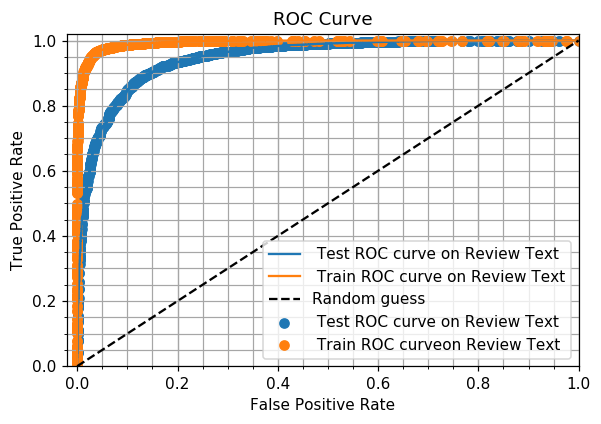

In [9]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr_test_bow_GBDT, tpr_test_bow_GBDT, thresholds = roc_curve(y_test_40k, pred_proba_test_bow_GBDT)
fpr_train_bow_GBDT, tpr_train_bow_GBDT, thresholds = roc_curve(y_train_40k, pred_proba_train_bow_GBDT)
# create plot
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.1
plt.plot(fpr_test_bow_GBDT, tpr_test_bow_GBDT, label=' Test ROC curve on Review Text')
plt.scatter(fpr_test_bow_GBDT, tpr_test_bow_GBDT, label=' Test ROC curve on Review Text')
plt.plot(fpr_train_bow_GBDT, tpr_train_bow_GBDT, label=' Train ROC curve on Review Text')
plt.scatter(fpr_train_bow_GBDT, tpr_train_bow_GBDT, label=' Train ROC curveon Review Text')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

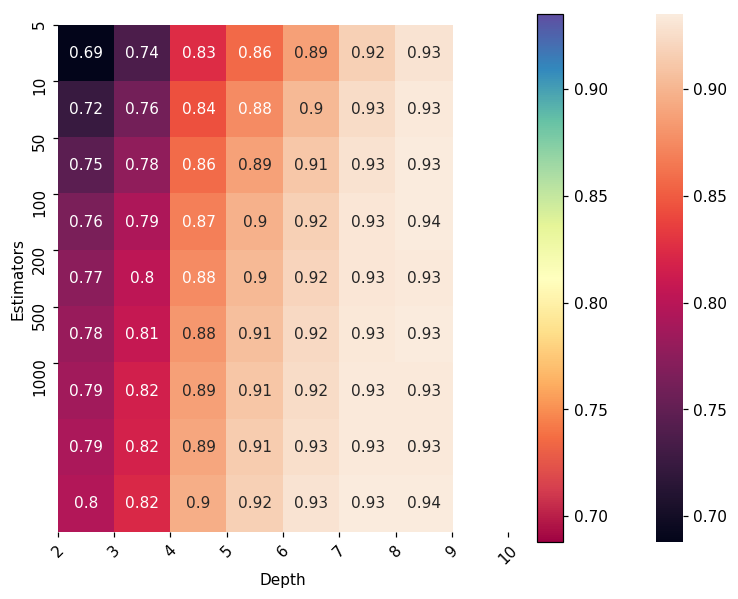

In [10]:
import numpy as np
import pylab as pl
import matplotlib.cm as cm
import seaborn as sns

Depth_gbdt = [2, 3, 4, 5, 6, 7, 8, 9, 10]
Estimators_gbdt = [5, 10, 50, 100, 200, 500, 1000]

# plot the scores of the grid
# grid_scores_ contains parameter settings and scores
score_dict_bow_GBDT = gbdt_lgbm_BOW.grid_scores_

# We extract just the scores
scores = [x[1] for x in score_dict_bow_GBDT]
scores = np.array(scores).reshape(len(Depth_gbdt), len(Estimators_gbdt))

# Make a nice figure
pl.figure(figsize=(8, 6))
pl.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
pl.imshow(scores, interpolation='nearest', cmap=cm.get_cmap("Spectral"))
ax = sns.heatmap(scores, annot=True)
pl.xlabel('Depth')
pl.ylabel('Estimators')
pl.colorbar()
pl.xticks(np.arange(len(Depth_gbdt)), Depth_gbdt, rotation=45)
pl.yticks(np.arange(len(Estimators_gbdt)), Estimators_gbdt)
pl.grid(False)
pl.show()


In [12]:
from sklearn.metrics import roc_auc_score
predict_GBDT_BOW_train = (gbdt_lgbm_BOW.predict(bow_X_train_no_stop_40k.astype(np.float32)))
predict_GBDT_BOW_test = gbdt_lgbm_BOW.predict(bow_X_test_no_stop_40k.astype(np.float32))

roc_auc_GBDT_BOW_train = roc_auc_score(y_test_40k, predict_GBDT_BOW_test)
roc_auc_GBDT_BOW_test = roc_auc_score(y_train_40k, predict_GBDT_BOW_train)



In [13]:
from sklearn.metrics import classification_report

print ("#######################################################")
print ("The classification report on Test dataset on Review Text")
print ("#######################################################")

print(classification_report(y_test_40k, predict_GBDT_BOW_test))


print ("#######################################################")
print ("The classification report on Training dataset Review Text")
print ("#######################################################")
print(classification_report(y_train_40k, predict_GBDT_BOW_train))



#######################################################
The classification report on Test dataset on Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.65      0.82      0.73      2156
          1       0.96      0.91      0.94     11044

avg / total       0.91      0.90      0.90     13200

#######################################################
The classification report on Training dataset Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.81      0.97      0.89      4707
          1       0.99      0.95      0.97     22093

avg / total       0.96      0.96      0.96     26800



The first matrix is that of Test in normalized format
The second matrix is that of Train in normalized format
The third matrix is that of Test in non normalized format
The fourth matrix is that of Train in non normalized format


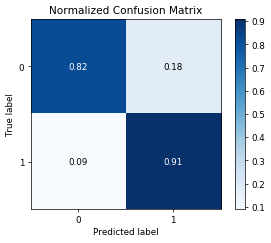

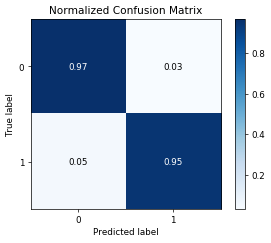

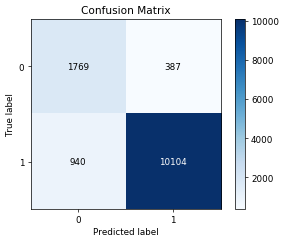

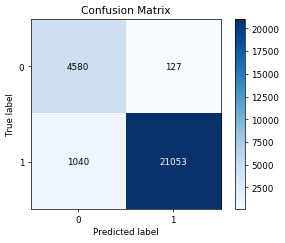

In [14]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_test_40k, predict_GBDT_BOW_test,normalize=True)
print ("The first matrix is that of Test in normalized format")
print ("The second matrix is that of Train in normalized format")
print ("The third matrix is that of Test in non normalized format")
print ("The fourth matrix is that of Train in non normalized format")
skplt.plot_confusion_matrix(y_train_40k, predict_GBDT_BOW_train,normalize=True)
skplt.plot_confusion_matrix(y_test_40k, predict_GBDT_BOW_test)
skplt.plot_confusion_matrix(y_train_40k, predict_GBDT_BOW_train)


### [5.2.2] Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

In [17]:
lgbm_GBDT_TFIDF = GridSearchCV(lgbm,param_grid,scoring='roc_auc',cv=3, verbose=2)
lgbm_GBDT_TFIDF.fit(tfidf_X_train,y_train_40k)
lgbm_GBDT_TFIDF.best_params_

Fitting 3 folds for each of 63 candidates, totalling 189 fits
[CV] max_depth=2, n_estimators=5 .....................................
[CV] ...................... max_depth=2, n_estimators=5, total=   0.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] max_depth=2, n_estimators=5 .....................................
[CV] ...................... max_depth=2, n_estimators=5, total=   0.3s
[CV] max_depth=2, n_estimators=5 .....................................
[CV] ...................... max_depth=2, n_estimators=5, total=   0.3s
[CV] max_depth=2, n_estimators=10 ....................................
[CV] ..................... max_depth=2, n_estimators=10, total=   0.3s
[CV] max_depth=2, n_estimators=10 ....................................
[CV] ..................... max_depth=2, n_estimators=10, total=   0.3s
[CV] max_depth=2, n_estimators=10 ....................................
[CV] ..................... max_depth=2, n_estimators=10, total=   0.4s
[CV] max_depth=2, n_estimators=50 ....................................
[CV] ..................... max_depth=2, n_estimators=50, total=   0.6s
[CV] max_depth=2, n_estimators=50 ....................................
[CV] ..................... max_depth=2, n_estimators=50, total=   0.7s
[CV] m

[CV] .................... max_depth=4, n_estimators=500, total=   7.5s
[CV] max_depth=4, n_estimators=500 ...................................
[CV] .................... max_depth=4, n_estimators=500, total=   7.4s
[CV] max_depth=4, n_estimators=1000 ..................................
[CV] ................... max_depth=4, n_estimators=1000, total=  14.1s
[CV] max_depth=4, n_estimators=1000 ..................................
[CV] ................... max_depth=4, n_estimators=1000, total=  14.2s
[CV] max_depth=4, n_estimators=1000 ..................................
[CV] ................... max_depth=4, n_estimators=1000, total=  14.3s
[CV] max_depth=5, n_estimators=5 .....................................
[CV] ...................... max_depth=5, n_estimators=5, total=   0.4s
[CV] max_depth=5, n_estimators=5 .....................................
[CV] ...................... max_depth=5, n_estimators=5, total=   0.4s
[CV] max_depth=5, n_estimators=5 .....................................
[CV] .

[CV] max_depth=7, n_estimators=100 ...................................
[CV] .................... max_depth=7, n_estimators=100, total=   3.3s
[CV] max_depth=7, n_estimators=200 ...................................
[CV] .................... max_depth=7, n_estimators=200, total=   5.8s
[CV] max_depth=7, n_estimators=200 ...................................
[CV] .................... max_depth=7, n_estimators=200, total=   5.8s
[CV] max_depth=7, n_estimators=200 ...................................
[CV] .................... max_depth=7, n_estimators=200, total=   5.8s
[CV] max_depth=7, n_estimators=500 ...................................
[CV] .................... max_depth=7, n_estimators=500, total=  12.7s
[CV] max_depth=7, n_estimators=500 ...................................
[CV] .................... max_depth=7, n_estimators=500, total=  12.9s
[CV] max_depth=7, n_estimators=500 ...................................
[CV] .................... max_depth=7, n_estimators=500, total=  13.0s
[CV] m

[CV] .................... max_depth=10, n_estimators=10, total=   0.8s
[CV] max_depth=10, n_estimators=50 ...................................
[CV] .................... max_depth=10, n_estimators=50, total=   2.5s
[CV] max_depth=10, n_estimators=50 ...................................
[CV] .................... max_depth=10, n_estimators=50, total=   2.5s
[CV] max_depth=10, n_estimators=50 ...................................
[CV] .................... max_depth=10, n_estimators=50, total=   2.5s
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ................... max_depth=10, n_estimators=100, total=   4.4s
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ................... max_depth=10, n_estimators=100, total=   4.4s
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ................... max_depth=10, n_estimators=100, total=   4.4s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 189 out of 189 | elapsed: 19.6min finished


{'max_depth': 5, 'n_estimators': 1000}

In [18]:
besthyperpara_tfidf_GBDT = LGBMClassifier(booster='gbtree',max_depth=5,n_estimators=1000)
besthyperpara_tfidf_GBDT.fit(tfidf_X_train,y_train_40k)
pred_proba_train_tfidf_GBDT=(besthyperpara_tfidf_GBDT.predict_proba(tfidf_X_train)[:,1])
pred_proba_test_tfidf_GBDT=(besthyperpara_tfidf_GBDT.predict_proba(tfidf_X_test)[:,1])
roc_auc_test_tfidf_GBDT= (roc_auc_score(y_test_40k,pred_proba_test_tfidf_GBDT))
roc_auc_train_tfidf_GBDT  = (roc_auc_score(y_train_40k,pred_proba_train_tfidf_GBDT))

In [19]:
print (roc_auc_test_tfidf_GBDT)
print (roc_auc_train_tfidf_GBDT)

0.9486868473147383
0.997686475151284


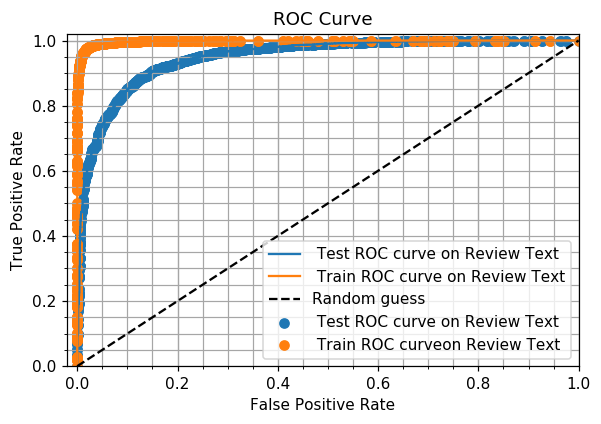

In [20]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr_test_tfidf_GBDT, tpr_test_tfidf_GBDT, thresholds = roc_curve(y_test_40k,pred_proba_test_tfidf_GBDT)
fpr_train_tfidf_GBDT, tpr_train_tfidf_GBDT, thresholds = roc_curve(y_train_40k,pred_proba_train_tfidf_GBDT)
# create plot
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.1
plt.plot(fpr_test_tfidf_GBDT, tpr_test_tfidf_GBDT, label=' Test ROC curve on Review Text')
plt.scatter(fpr_test_tfidf_GBDT, tpr_test_tfidf_GBDT, label=' Test ROC curve on Review Text')
plt.plot(fpr_train_tfidf_GBDT, tpr_train_tfidf_GBDT, label=' Train ROC curve on Review Text')
plt.scatter(fpr_train_tfidf_GBDT, tpr_train_tfidf_GBDT, label=' Train ROC curveon Review Text')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [21]:
from sklearn.metrics import roc_auc_score
predict_GBDT_tfidf_train = lgbm_GBDT_TFIDF.predict(tfidf_X_train)
predict_GBDT_tfidf_test = lgbm_GBDT_TFIDF.predict(tfidf_X_test)

roc_auc_GBDT_tfidf_train = roc_auc_score(y_test_40k, predict_GBDT_tfidf_test)
roc_auc_GBDT_tfidf_test = roc_auc_score(y_train_40k, predict_GBDT_tfidf_train)

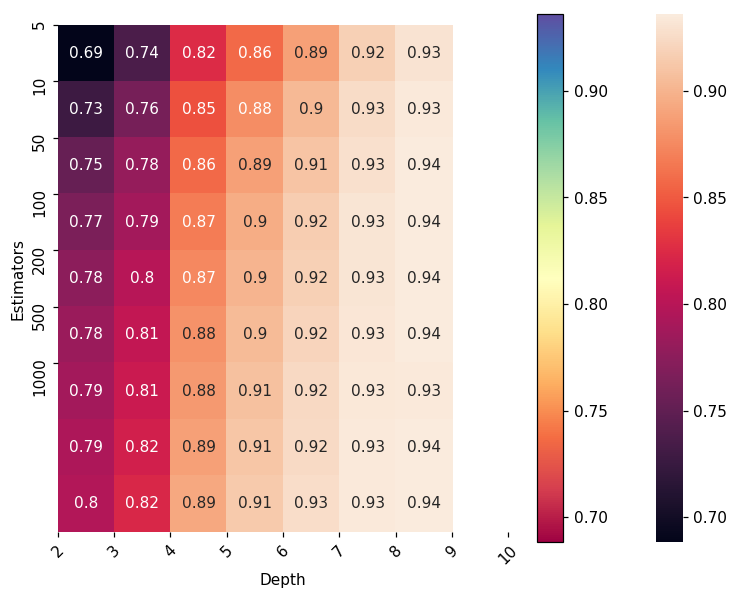

In [22]:
import numpy as np
import pylab as pl
import matplotlib.cm as cm
import seaborn as sns

# plot the scores of the grid
# grid_scores_ contains parameter settings and scores
score_dict_tfidf_GBDT = lgbm_GBDT_TFIDF.grid_scores_

# We extract just the scores
scores = [x[1] for x in score_dict_tfidf_GBDT]
scores = np.array(scores).reshape(len(Depth_gbdt), len(Estimators_gbdt))

# Make a nice figure
pl.figure(figsize=(8, 6))
pl.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
pl.imshow(scores, interpolation='nearest', cmap=cm.get_cmap("Spectral"))
ax = sns.heatmap(scores, annot=True)
pl.xlabel('Depth')
pl.ylabel('Estimators')
pl.colorbar()
pl.xticks(np.arange(len(Depth_gbdt)), Depth_gbdt, rotation=45)
pl.yticks(np.arange(len(Estimators_gbdt)), Estimators_gbdt)
pl.grid(False)
pl.show()

In [23]:
from sklearn.metrics import classification_report

print ("#######################################################")
print ("The classification report on Test dataset on Review Text")
print ("#######################################################")

print(classification_report(y_test_40k, predict_GBDT_tfidf_test))


print ("#######################################################")
print ("The classification report on Training dataset Review Text")
print ("#######################################################")
print(classification_report(y_train_40k, predict_GBDT_tfidf_train))

#######################################################
The classification report on Test dataset on Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.67      0.81      0.73      2156
          1       0.96      0.92      0.94     11044

avg / total       0.91      0.90      0.91     13200

#######################################################
The classification report on Training dataset Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.85      0.99      0.91      4707
          1       1.00      0.96      0.98     22093

avg / total       0.97      0.97      0.97     26800



The first matrix is that of Test in normalized format
The second matrix is that of Train in normalized format
The third matrix is that of Test in non normalized format
The fourth matrix is that of Train in non normalized format


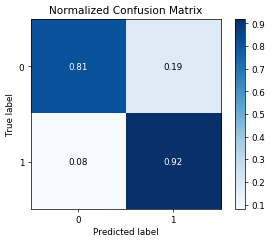

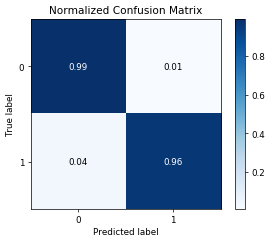

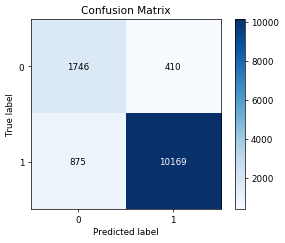

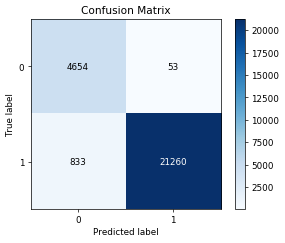

In [24]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_test_40k, predict_GBDT_tfidf_test,normalize=True)
print ("The first matrix is that of Test in normalized format")
print ("The second matrix is that of Train in normalized format")
print ("The third matrix is that of Test in non normalized format")
print ("The fourth matrix is that of Train in non normalized format")
skplt.plot_confusion_matrix(y_train_40k, predict_GBDT_tfidf_train,normalize=True)
skplt.plot_confusion_matrix(y_test_40k, predict_GBDT_tfidf_test)
skplt.plot_confusion_matrix(y_train_40k, predict_GBDT_tfidf_train)

### [5.2.3] Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

In [28]:
# https://github.com/niketan108/RF-and-GBDT-using-XGBOOST-on-amazon-food-dataset/blob/master/09%20Amazon%20Fine%20Food%20Reviews%20Analysis_RF.ipynb

avgw2v_train= np.array(sent_vectors_train)
print(avgw2v_train.shape)
avgw2v_test= np.array(sent_vectors_test)
print(avgw2v_test.shape)

(26800, 50)
(13200, 50)


In [29]:
lgbm_GBDT_avgw2v = GridSearchCV(lgbm,param_grid,scoring='roc_auc',cv=3, verbose=2)
lgbm_GBDT_avgw2v.fit(avgw2v_train,y_train_40k)


Fitting 3 folds for each of 63 candidates, totalling 189 fits
[CV] max_depth=2, n_estimators=5 .....................................
[CV] ...................... max_depth=2, n_estimators=5, total=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] max_depth=2, n_estimators=5 .....................................
[CV] ...................... max_depth=2, n_estimators=5, total=   0.0s
[CV] max_depth=2, n_estimators=5 .....................................
[CV] ...................... max_depth=2, n_estimators=5, total=   0.0s
[CV] max_depth=2, n_estimators=10 ....................................
[CV] ..................... max_depth=2, n_estimators=10, total=   0.0s
[CV] max_depth=2, n_estimators=10 ....................................
[CV] ..................... max_depth=2, n_estimators=10, total=   0.0s
[CV] max_depth=2, n_estimators=10 ....................................
[CV] ..................... max_depth=2, n_estimators=10, total=   0.0s
[CV] max_depth=2, n_estimators=50 ....................................
[CV] ..................... max_depth=2, n_estimators=50, total=   0.1s
[CV] max_depth=2, n_estimators=50 ....................................
[CV] ..................... max_depth=2, n_estimators=50, total=   0.1s
[CV] m

[CV] .................... max_depth=4, n_estimators=500, total=   1.9s
[CV] max_depth=4, n_estimators=500 ...................................
[CV] .................... max_depth=4, n_estimators=500, total=   1.9s
[CV] max_depth=4, n_estimators=1000 ..................................
[CV] ................... max_depth=4, n_estimators=1000, total=   3.9s
[CV] max_depth=4, n_estimators=1000 ..................................
[CV] ................... max_depth=4, n_estimators=1000, total=   3.9s
[CV] max_depth=4, n_estimators=1000 ..................................
[CV] ................... max_depth=4, n_estimators=1000, total=   3.8s
[CV] max_depth=5, n_estimators=5 .....................................
[CV] ...................... max_depth=5, n_estimators=5, total=   0.0s
[CV] max_depth=5, n_estimators=5 .....................................
[CV] ...................... max_depth=5, n_estimators=5, total=   0.0s
[CV] max_depth=5, n_estimators=5 .....................................
[CV] .

[CV] max_depth=7, n_estimators=100 ...................................
[CV] .................... max_depth=7, n_estimators=100, total=   0.9s
[CV] max_depth=7, n_estimators=200 ...................................
[CV] .................... max_depth=7, n_estimators=200, total=   1.6s
[CV] max_depth=7, n_estimators=200 ...................................
[CV] .................... max_depth=7, n_estimators=200, total=   1.6s
[CV] max_depth=7, n_estimators=200 ...................................
[CV] .................... max_depth=7, n_estimators=200, total=   1.6s
[CV] max_depth=7, n_estimators=500 ...................................
[CV] .................... max_depth=7, n_estimators=500, total=   3.8s
[CV] max_depth=7, n_estimators=500 ...................................
[CV] .................... max_depth=7, n_estimators=500, total=   3.8s
[CV] max_depth=7, n_estimators=500 ...................................
[CV] .................... max_depth=7, n_estimators=500, total=   3.7s
[CV] m

[CV] .................... max_depth=10, n_estimators=10, total=   0.1s
[CV] max_depth=10, n_estimators=50 ...................................
[CV] .................... max_depth=10, n_estimators=50, total=   0.5s
[CV] max_depth=10, n_estimators=50 ...................................
[CV] .................... max_depth=10, n_estimators=50, total=   0.5s
[CV] max_depth=10, n_estimators=50 ...................................
[CV] .................... max_depth=10, n_estimators=50, total=   0.5s
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ................... max_depth=10, n_estimators=100, total=   1.0s
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ................... max_depth=10, n_estimators=100, total=   1.0s
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ................... max_depth=10, n_estimators=100, total=   0.9s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 189 out of 189 | elapsed:  5.6min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
        objective=None, random_state=5, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'n_estimators': [5, 10, 50, 100, 200, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [30]:
lgbm_GBDT_avgw2v.best_params_

{'max_depth': 9, 'n_estimators': 100}

In [31]:
besthyperpara_avgw2v_GBDT = LGBMClassifier(booster='gbtree',max_depth=9,n_estimators=100)
besthyperpara_avgw2v_GBDT.fit(avgw2v_train,y_train_40k)
pred_proba_train_avgw2v_GBDT=(besthyperpara_avgw2v_GBDT.predict_proba(avgw2v_train)[:,1])
pred_proba_test_avgw2v_GBDT=(besthyperpara_avgw2v_GBDT.predict_proba(avgw2v_test)[:,1])
roc_auc_test_avgw2v_GBDT= (roc_auc_score(y_test_40k,pred_proba_test_avgw2v_GBDT))
roc_auc_train_avgw2v_GBDT  = (roc_auc_score(y_train_40k,pred_proba_train_avgw2v_GBDT))


In [32]:
print (roc_auc_test_avgw2v_GBDT)
print (roc_auc_train_avgw2v_GBDT)

0.8931354611911605
0.9611289120422639


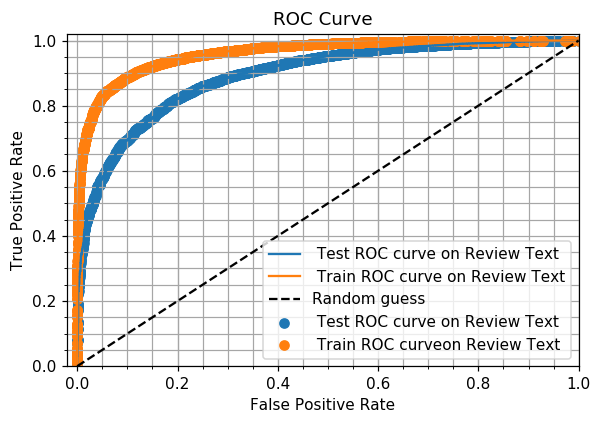

In [33]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr_test_avgw2v_GBDT, tpr_test_avgw2v_GBDT, thresholds = roc_curve(y_test_40k,pred_proba_test_avgw2v_GBDT)
fpr_train_avgw2v_GBDT, tpr_train_avgw2v_GBDT, thresholds = roc_curve(y_train_40k,pred_proba_train_avgw2v_GBDT)
# create plot
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.1
plt.plot(fpr_test_avgw2v_GBDT, tpr_test_avgw2v_GBDT, label=' Test ROC curve on Review Text')
plt.scatter(fpr_test_avgw2v_GBDT, tpr_test_avgw2v_GBDT, label=' Test ROC curve on Review Text')
plt.plot(fpr_train_avgw2v_GBDT, tpr_train_avgw2v_GBDT, label=' Train ROC curve on Review Text')
plt.scatter(fpr_train_avgw2v_GBDT, tpr_train_avgw2v_GBDT, label=' Train ROC curveon Review Text')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

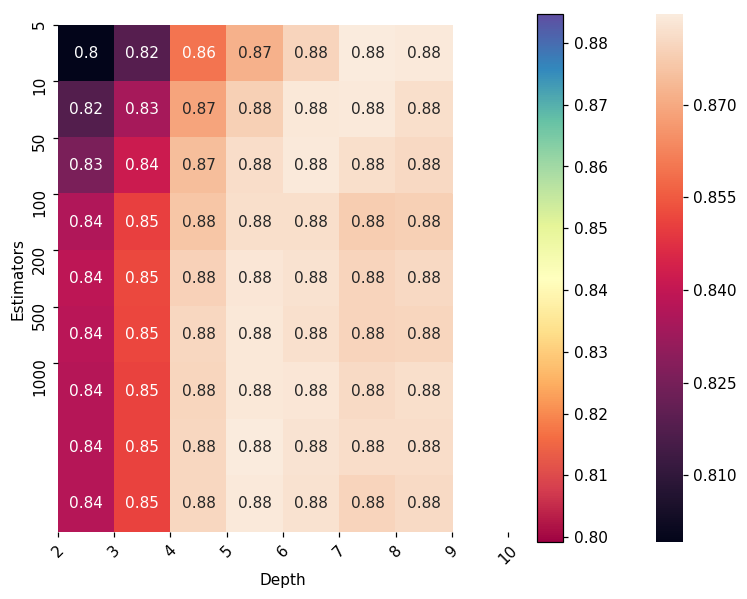

In [35]:
import numpy as np
import pylab as pl
import matplotlib.cm as cm
import seaborn as sns

# plot the scores of the grid
# grid_scores_ contains parameter settings and scores
score_dict_avgw2v_gbdt = lgbm_GBDT_avgw2v.grid_scores_

# We extract just the scores
scores = [x[1] for x in score_dict_avgw2v_gbdt]
scores = np.array(scores).reshape(len(Depth_gbdt), len(Estimators_gbdt))

# Make a nice figure
pl.figure(figsize=(8, 6))
pl.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
pl.imshow(scores, interpolation='nearest', cmap=cm.get_cmap("Spectral"))
ax = sns.heatmap(scores, annot=True)
pl.xlabel('Depth')
pl.ylabel('Estimators')
pl.colorbar()
pl.xticks(np.arange(len(Depth_gbdt)), Depth_gbdt, rotation=45)
pl.yticks(np.arange(len(Estimators_gbdt)), Estimators_gbdt)
pl.grid(False)
pl.show()

In [36]:
from sklearn.metrics import roc_auc_score
predict_gbdt_avgw2v_train = lgbm_GBDT_avgw2v.predict(avgw2v_train)
predict_gbdt_avgw2v_test = lgbm_GBDT_avgw2v.predict(avgw2v_test)


In [37]:
from sklearn.metrics import classification_report

print ("#######################################################")
print ("The classification report on Test dataset on Review Text")
print ("#######################################################")

print(classification_report(y_test_40k, predict_gbdt_avgw2v_test))


print ("#######################################################")
print ("The classification report on Training dataset Review Text")
print ("#######################################################")
print(classification_report(y_train_40k, predict_gbdt_avgw2v_train))

#######################################################
The classification report on Test dataset on Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.49      0.76      0.60      2156
          1       0.95      0.85      0.90     11044

avg / total       0.87      0.83      0.85     13200

#######################################################
The classification report on Training dataset Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.59      0.93      0.72      4707
          1       0.98      0.86      0.92     22093

avg / total       0.91      0.87      0.88     26800



In [38]:
roc_auc_gbdt_avgw2v_train = roc_auc_score(y_test_40k, predict_gbdt_avgw2v_test)
roc_auc_gbdt_avgw2v_test = roc_auc_score(y_train_40k, predict_gbdt_avgw2v_train)

The first matrix is that of Test in normalized format
The second matrix is that of Train in normalized format
The third matrix is that of Test in non normalized format
The fourth matrix is that of Train in non normalized format


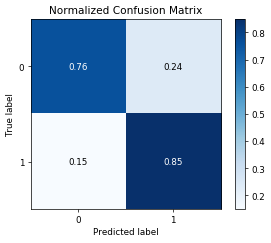

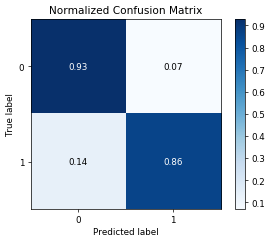

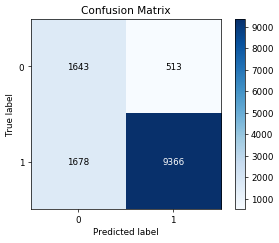

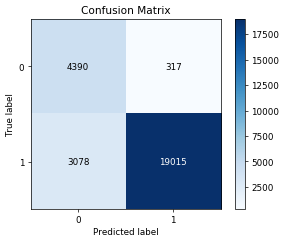

In [39]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_test_40k, predict_gbdt_avgw2v_test,normalize=True)
print ("The first matrix is that of Test in normalized format")
print ("The second matrix is that of Train in normalized format")
print ("The third matrix is that of Test in non normalized format")
print ("The fourth matrix is that of Train in non normalized format")
skplt.plot_confusion_matrix(y_train_40k, predict_gbdt_avgw2v_train,normalize=True)
skplt.plot_confusion_matrix(y_test_40k, predict_gbdt_avgw2v_test)
skplt.plot_confusion_matrix(y_train_40k, predict_gbdt_avgw2v_train)

### [5.2.4] Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

In [43]:
tfidfw2v_train= np.array(tfidf_w2v_sent_vectors_train)
tfidf2v_test= np.array(tfidf_w2v_sent_vectors_test)

lgbm_GBDT_tfidfw2v = GridSearchCV(lgbm,param_grid,scoring='roc_auc',cv=3, verbose=2)
lgbm_GBDT_tfidfw2v.fit(tfidfw2v_train,y_train_40k)

Fitting 3 folds for each of 63 candidates, totalling 189 fits
[CV] max_depth=2, n_estimators=5 .....................................
[CV] ...................... max_depth=2, n_estimators=5, total=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] max_depth=2, n_estimators=5 .....................................
[CV] ...................... max_depth=2, n_estimators=5, total=   0.0s
[CV] max_depth=2, n_estimators=5 .....................................
[CV] ...................... max_depth=2, n_estimators=5, total=   0.0s
[CV] max_depth=2, n_estimators=10 ....................................
[CV] ..................... max_depth=2, n_estimators=10, total=   0.0s
[CV] max_depth=2, n_estimators=10 ....................................
[CV] ..................... max_depth=2, n_estimators=10, total=   0.0s
[CV] max_depth=2, n_estimators=10 ....................................
[CV] ..................... max_depth=2, n_estimators=10, total=   0.0s
[CV] max_depth=2, n_estimators=50 ....................................
[CV] ..................... max_depth=2, n_estimators=50, total=   0.1s
[CV] max_depth=2, n_estimators=50 ....................................
[CV] ..................... max_depth=2, n_estimators=50, total=   0.1s
[CV] m

[CV] .................... max_depth=4, n_estimators=500, total=   2.0s
[CV] max_depth=4, n_estimators=500 ...................................
[CV] .................... max_depth=4, n_estimators=500, total=   2.0s
[CV] max_depth=4, n_estimators=1000 ..................................
[CV] ................... max_depth=4, n_estimators=1000, total=   4.0s
[CV] max_depth=4, n_estimators=1000 ..................................
[CV] ................... max_depth=4, n_estimators=1000, total=   3.9s
[CV] max_depth=4, n_estimators=1000 ..................................
[CV] ................... max_depth=4, n_estimators=1000, total=   3.9s
[CV] max_depth=5, n_estimators=5 .....................................
[CV] ...................... max_depth=5, n_estimators=5, total=   0.0s
[CV] max_depth=5, n_estimators=5 .....................................
[CV] ...................... max_depth=5, n_estimators=5, total=   0.0s
[CV] max_depth=5, n_estimators=5 .....................................
[CV] .

[CV] max_depth=7, n_estimators=100 ...................................
[CV] .................... max_depth=7, n_estimators=100, total=   0.9s
[CV] max_depth=7, n_estimators=200 ...................................
[CV] .................... max_depth=7, n_estimators=200, total=   1.6s
[CV] max_depth=7, n_estimators=200 ...................................
[CV] .................... max_depth=7, n_estimators=200, total=   1.6s
[CV] max_depth=7, n_estimators=200 ...................................
[CV] .................... max_depth=7, n_estimators=200, total=   1.6s
[CV] max_depth=7, n_estimators=500 ...................................
[CV] .................... max_depth=7, n_estimators=500, total=   3.7s
[CV] max_depth=7, n_estimators=500 ...................................
[CV] .................... max_depth=7, n_estimators=500, total=   3.7s
[CV] max_depth=7, n_estimators=500 ...................................
[CV] .................... max_depth=7, n_estimators=500, total=   3.7s
[CV] m

[CV] .................... max_depth=10, n_estimators=10, total=   0.1s
[CV] max_depth=10, n_estimators=50 ...................................
[CV] .................... max_depth=10, n_estimators=50, total=   0.5s
[CV] max_depth=10, n_estimators=50 ...................................
[CV] .................... max_depth=10, n_estimators=50, total=   0.5s
[CV] max_depth=10, n_estimators=50 ...................................
[CV] .................... max_depth=10, n_estimators=50, total=   0.5s
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ................... max_depth=10, n_estimators=100, total=   0.9s
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ................... max_depth=10, n_estimators=100, total=   0.9s
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ................... max_depth=10, n_estimators=100, total=   1.0s
[CV] max_depth=10, n_estimators=200 ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 189 out of 189 | elapsed:  5.6min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
        objective=None, random_state=5, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'n_estimators': [5, 10, 50, 100, 200, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [44]:
lgbm_GBDT_tfidfw2v.best_params_

{'max_depth': 2, 'n_estimators': 1000}

In [53]:
besthyperpara_tfidfw2v_GBDT = LGBMClassifier(booster='gbtree',max_depth=2,n_estimators=1000)
besthyperpara_tfidfw2v_GBDT.fit(tfidfw2v_train,y_train_40k)
pred_proba_train_tfidfw2v_GBDT=(besthyperpara_tfidfw2v_GBDT.predict_proba(tfidfw2v_train)[:,1])
pred_proba_test_tfidfw2v_GBDT=(besthyperpara_tfidfw2v_GBDT.predict_proba(tfidf2v_test)[:,1])
roc_auc_test_tfidfw2v_GBDT= (roc_auc_score(y_test_40k,pred_proba_test_tfidfw2v_GBDT))
roc_auc_train_tfidfw2v_GBDT  = (roc_auc_score(y_train_40k,pred_proba_train_tfidfw2v_GBDT))

In [54]:
print (roc_auc_test_tfidfw2v_GBDT)
print (roc_auc_train_tfidfw2v_GBDT)

0.8716520324503976
0.9216072099795685


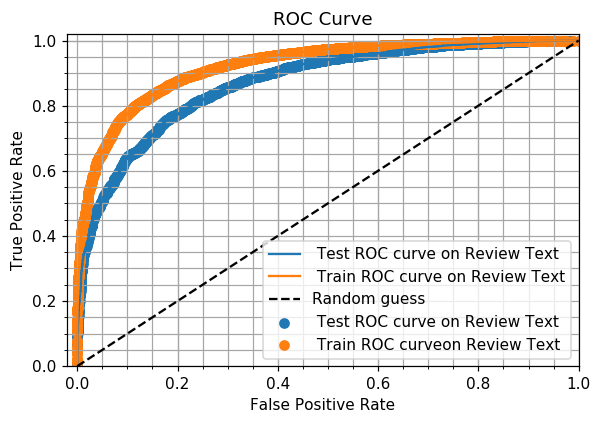

In [55]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr_test_tfidfw2v_GBDT, tpr_test_tfidfw2v_GBDT, thresholds = roc_curve(y_test_40k,pred_proba_test_tfidfw2v_GBDT)
fpr_train_tfidfw2v_GBDT, tpr_train_tfidfw2v_GBDT, thresholds = roc_curve(y_train_40k,pred_proba_train_tfidfw2v_GBDT)
# create plot
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1.1
plt.plot(fpr_test_tfidfw2v_GBDT, tpr_test_tfidfw2v_GBDT, label=' Test ROC curve on Review Text')
plt.scatter(fpr_test_tfidfw2v_GBDT, tpr_test_tfidfw2v_GBDT, label=' Test ROC curve on Review Text')
plt.plot(fpr_train_tfidfw2v_GBDT, tpr_train_tfidfw2v_GBDT, label=' Train ROC curve on Review Text')
plt.scatter(fpr_train_tfidfw2v_GBDT, tpr_train_tfidfw2v_GBDT, label=' Train ROC curveon Review Text')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.minorticks_on()
plt.grid(b=True, which='both', color='0.65', linestyle='-')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

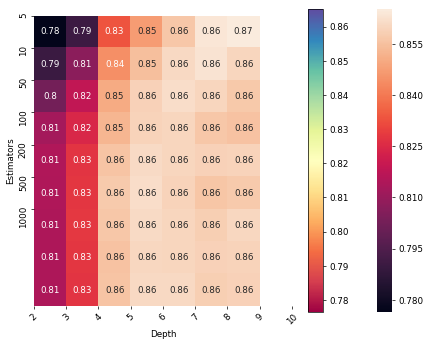

In [63]:
import numpy as np
import pylab as pl
import matplotlib.cm as cm
import seaborn as sns

# plot the scores of the grid
# grid_scores_ contains parameter settings and scores
score_dict_tfidfw2v_gbdt = lgbm_GBDT_tfidfw2v.grid_scores_

# We extract just the scores
scores = [x[1] for x in score_dict_tfidfw2v_gbdt]
scores = np.array(scores).reshape(len(Depth_gbdt), len(Estimators_gbdt))

# Make a nice figure
pl.figure(figsize=(8, 6))
pl.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
pl.imshow(scores, interpolation='nearest', cmap=cm.get_cmap("Spectral"))
ax = sns.heatmap(scores, annot=True)
pl.xlabel('Depth')
pl.ylabel('Estimators')
pl.colorbar()
pl.xticks(np.arange(len(Depth_gbdt)), Depth_gbdt, rotation=45)
pl.yticks(np.arange(len(Estimators_gbdt)), Estimators_gbdt)
pl.grid(False)
pl.show()

In [57]:
from sklearn.metrics import roc_auc_score
predict_gbdt_tfidfw2v_train = lgbm_GBDT_tfidfw2v.predict(tfidfw2v_train)
predict_gbdt_tfidfw2v_test = lgbm_GBDT_tfidfw2v.predict(tfidf2v_test)


In [58]:
from sklearn.metrics import classification_report

print ("#######################################################")
print ("The classification report on Test dataset on Review Text")
print ("#######################################################")

print(classification_report(y_test_40k, predict_gbdt_tfidfw2v_test))


print ("#######################################################")
print ("The classification report on Training dataset Review Text")
print ("#######################################################")
print(classification_report(y_train_40k, predict_gbdt_tfidfw2v_train))




#######################################################
The classification report on Test dataset on Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.45      0.75      0.56      2156
          1       0.94      0.82      0.88     11044

avg / total       0.86      0.81      0.83     13200

#######################################################
The classification report on Training dataset Review Text
#######################################################
             precision    recall  f1-score   support

          0       0.51      0.87      0.65      4707
          1       0.97      0.82      0.89     22093

avg / total       0.89      0.83      0.85     26800



In [59]:
roc_auc_gbdt_avgw2v_train = roc_auc_score(y_test_40k, predict_gbdt_tfidfw2v_test)
roc_auc_gbdt_avgw2v_test = roc_auc_score(y_train_40k, predict_gbdt_tfidfw2v_train)


The first matrix is that of Test in normalized format
The second matrix is that of Train in normalized format
The third matrix is that of Test in non normalized format
The fourth matrix is that of Train in non normalized format


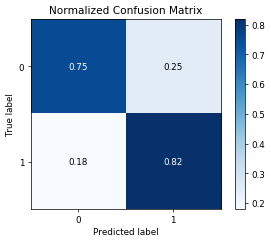

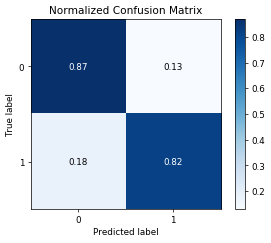

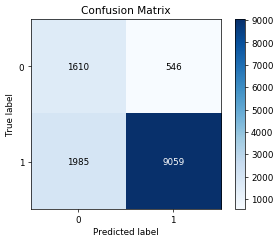

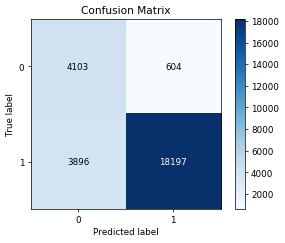

In [60]:
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*.63
skplt.plot_confusion_matrix(y_test_40k, predict_gbdt_tfidfw2v_test,normalize=True)
print ("The first matrix is that of Test in normalized format")
print ("The second matrix is that of Train in normalized format")
print ("The third matrix is that of Test in non normalized format")
print ("The fourth matrix is that of Train in non normalized format")
skplt.plot_confusion_matrix(y_train_40k, predict_gbdt_tfidfw2v_train,normalize=True)
skplt.plot_confusion_matrix(y_test_40k, predict_gbdt_tfidfw2v_test)
skplt.plot_confusion_matrix(y_train_40k, predict_gbdt_tfidfw2v_train)

# [6] Conclusions

In [148]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Algorithm","Hyper-Parameter", "AUC"]

x.add_row(["Random Forest BOW Test", "'max_depth': 500, 'n_estimators': 1000",roc_auc_test_bow_RF])
x.add_row(["Random Forest BOW Train", "'max_depth': 500, 'n_estimators': 1000",roc_auc_train_bow_RF])
x.add_row(["Random Forest TFIDF Test", "'max_depth': 500, 'n_estimators': 1000" ,roc_auc_test_tfidf_RF])
x.add_row(["Random Forest TFIDF Train", "'max_depth': 500, 'n_estimators': 1000" ,roc_auc_train_tfidf_RF])
x.add_row(["Random Forest AVGW2V Test","'max_depth': 50, 'n_estimators': 1000", roc_auc_test_avgw2v_RF])
x.add_row(["Random Forest AVGW2V  Train","'max_depth': 50, 'n_estimators': 1000",roc_auc_train_avgw2v_RF])
x.add_row(["Random Forest TFIDF-W2V (Test)","'max_depth': 50, 'n_estimators': 1000",roc_auc_test_tfidfw2v_RF_])
x.add_row(["Random Forest TFIDF-W2V (Train)","'max_depth': 50, 'n_estimators': 1000",roc_auc_train_tfidfw2v_RF])


+---------------------------------+----------------------------------------+--------------------+
|            Algorithm            |            Hyper-Parameter             |        AUC         |
+---------------------------------+----------------------------------------+--------------------+
|      Random Forest BOW Test     | 'max_depth': 500, 'n_estimators': 1000 | 0.9378371780209235 |
|     Random Forest BOW Train     | 'max_depth': 500, 'n_estimators': 1000 | 0.9999999951919264 |
|     Random Forest TFIDF Test    | 'max_depth': 500, 'n_estimators': 1000 | 0.9395840276942493 |
|    Random Forest TFIDF Train    | 'max_depth': 500, 'n_estimators': 1000 | 0.9999999951919263 |
|    Random Forest AVGW2V Test    | 'max_depth': 50, 'n_estimators': 1000  | 0.885367095456931  |
|   Random Forest AVGW2V  Train   | 'max_depth': 50, 'n_estimators': 1000  | 0.9999999951919263 |
|  Random Forest TFIDF-W2V (Test) | 'max_depth': 50, 'n_estimators': 1000  | 0.8640147203394215 |
| Random Forest TFID

In [65]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Algorithm","Hyper-Parameter", "AUC"]

x.add_row(["GBDT BOW Test", "'max_depth': 5, 'n_estimators': 1000",roc_auc_test_bow_GBDT])
x.add_row(["GBDT BOW Train","'max_depth': 5, 'n_estimators': 1000",roc_auc_train_bow_GBDT])
x.add_row(["GBDT TFIDF Test","'max_depth': 5, 'n_estimators': 1000",roc_auc_test_tfidf_GBDT])
x.add_row(["GBDT TFIDF Train","'max_depth': 5, 'n_estimators': 1000",roc_auc_train_tfidf_GBDT])
x.add_row(["GBDT AVGW2V Test","'max_depth': 9, 'n_estimators': 100",roc_auc_test_avgw2v_GBDT])
x.add_row(["GBDT AVGW2V Train","'max_depth': 9, 'n_estimators': 100",roc_auc_train_avgw2v_GBDT])
x.add_row(["GBDT TFIDFW2V Test","'max_depth': 2, 'n_estimators': 1000",roc_auc_test_tfidfw2v_GBDT])
x.add_row(["GBDT TFIDFW2V Train","'max_depth': 2, 'n_estimators': 1000",roc_auc_train_tfidfw2v_GBDT])

print (x)


+---------------------+--------------------------------------+--------------------+
|      Algorithm      |           Hyper-Parameter            |        AUC         |
+---------------------+--------------------------------------+--------------------+
|    GBDT BOW Test    | 'max_depth': 5, 'n_estimators': 1000 | 0.9479107939972276 |
|    GBDT BOW Train   | 'max_depth': 5, 'n_estimators': 1000 | 0.9938625083829966 |
|   GBDT TFIDF Test   | 'max_depth': 5, 'n_estimators': 1000 | 0.9486868473147383 |
|   GBDT TFIDF Train  | 'max_depth': 5, 'n_estimators': 1000 | 0.997686475151284  |
|   GBDT AVGW2V Test  | 'max_depth': 9, 'n_estimators': 100  | 0.8931354611911605 |
|  GBDT AVGW2V Train  | 'max_depth': 9, 'n_estimators': 100  | 0.9611289120422639 |
|  GBDT TFIDFW2V Test | 'max_depth': 2, 'n_estimators': 1000 | 0.8716520324503976 |
| GBDT TFIDFW2V Train | 'max_depth': 2, 'n_estimators': 1000 | 0.9216072099795685 |
+---------------------+--------------------------------------+--------------

1. If we compare Random Forest and GBDT it is very evident GBDT performed a lot better than RF. Also there is a tendency in RF to overfit as we see it has performed "too good" on training data and "too bad" on test data

2. Of BOW,TFIDF,AVG-W2V and TFIDF-W2V the best performance is that of BOW 
3. Also comparing the time taken in model BOW and TFIDF performed better than other two algorithms